In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, f1_score, precision_score,
    recall_score, accuracy_score, roc_auc_score, classification_report
)
from sklearn.preprocessing import StandardScaler
from matplotlib.dates import YearLocator, DateFormatter

## Poject: <a style="color:purple;">**Analysis of the US Economy**</a> - part 2

#### Author: @**engine**, Date: November 2024

### Abstract:
TODO

### 1. **Defining the problem and main assumptions**

In the **first part** of this study, looking at the distribution of funds from the US budget, we did not see good prospects in the future. It is not invested in the development of the USA, but in the wars, their consequences and the interest on the loans taken.
The share of interest payments on borrowed loans is also very large. The almost direct linear dependence of the expansion of the economy on inflation (printing money) and borrowing was also shown. The latter, since the dollar is a world currency, means printing money again. As a result of all that has been said so far, we can safely summarize that the American economy is addicted to printing new money. The trade balance is strongly negative with a worsening trend. Science is not a priority. If for some reason the printing of new money stops and/or the dollars of the world go "home" to the USA, we are waiting for "Great Depression - 2".

From here, we can ask ourselves the following question: <a style="color:purple;">**Can we use ML to predict approximately when the US economy will go into recession?**</a><br>The **second part** of the present study will be based on the answer to this question.

There are **2 main theoretical assumptions** at play:<br>
1. U.S. recessions exhibit markers / early warning signs.<br>
There exist plenty of recession “signals” in the form of individual economic or market data series. While individually, these signals have limited information value, they may become more useful when combined together.
2. Future recessions will be similar to historical recessions.<br>
This assumption is a lot more shaky, but can be mitigated by choosing features that maintain significance despite the changing economic landscape. For example, focusing on manufacturing data may have been relevant historically, but may be less relevant going forward as the world goes digital.

**What Have Others Tried?**

 - **Guggenheim Partners** has 2 recession related indicators: a Recession Probability Model and a Recession Dashboard, both driven by a combination of economic and market indicators. They try to predict recession probabilities across 3 different time frames.
 - **New York FED** predicts recession probabilities. Its limitations are that it only provides a 12-month forecast, and it only relies on 1 variable (the spread between the 10-year and 3-month Treasury rates).
 - **Rabobank** has a recession probability model, but it is also only based on 1 variable (the spread between the 10-year and 1-year Treasury rates), and only covers one time period (17-months).
 - **Wells Fargo Economics** has a few recession probability models that use a combination of economic and market data. However, they only limit their forecast to a 6-month horizon. [1]

**Model Benchmarking / Comparison**

Ideally, I would compare my model performance to each of the alternatives above. Currently, I cannot do this for the following reasons:

 - **Guggenheim model**: Model performance data is not publicly released.
 - **New York FED** model: Upon closer inspection, their model is built to answer the question “what is the probability that the U.S. will be in a recession X months from now?”, whereas my model is built to answer the question “what is the probability that the U.S. will be in a recession within the next X months?”.
 - **Rabobank model**: The same reason. Additionally, the Rabobank model covers a 17-month time period, whereas my model covers 6-month time periods.
 - **Moody’s economists team** model: Model performance data is not publicly released.
 - **Wells Fargo Economics** model: Model performance data is not publicly released. [1]
 - **STATISTA** has a recession probability model from August 2020 to August 2025. Well paid access service.

### 2. **Preparing the Data**

#### 2.1 Criteria according to which the data for the present study were collected.

Some things I had to consider when getting the data:

 - **Economic data are released at different frequencies** (weekly, monthly, quarterly, etc.). To time-match data points, I settled for only using data that could be sampled monthly. As a result, all predictions must be conducted at a monthly frequency.
 - **Varying data history lengths**. Some data has been released since 1919, while other data only goes back a few years. This means I had to exclude potentially useful data that just didn’t have enough history.
 - **Speaking of history**, I needed enough data to encompass as many recessions as I could. In the end, the full data set included 8 recessions since 1966.
 - **Economic data gets revised often**. FRED (Federal Reserve Economic Data) does not provide the original figures. It only provides the revised figures (no matter how far after-the-fact those revisions are made).
 - **Rare-event prediction**: Recessions are rare.
 - **Small data set**: Because I am using economic data (which is updated at a frequency of months), I will only have a few hundred data points to work with.
 - For practical reasons, I used mostly **public domain data** available through **[FRED](https://fred.stlouisfed.org/)** and **[Stooq](https://stooq.com/)**. I did not use potentially useful data that is stuck behind a paywall, such as [The Conference Board Leading Economic Index](https://www.conference-board.org/topics/us-leading-indicators).

#### 2.2 Feature Selection.

Some project-specific considerations for feature selection: <br> 
- **Curse of Dimensionality**. Since the data set is so small (only a few hundred data points), one cannot include too many features in the final model. Otherwise, the model will fail to generalize to out-of-sample data. Therefore, features must be carefully chosen for the incremental value that each feature provides.
- **Domain knowledge is key**. Since the underlying process is a complex time series, automated feature selection methods have a high risk of over-fitting to prior data. Therefore, feature selection must be guided by a solid understanding of economic fundamentals.

**A general outline for feature-selection process**:

 - Define the data set on which to perform exploratory data analysis (Jan 1962 to Dec 2012, Jan 2013 to Sep 2024) to ensure no intersection with cross-validation periods.
 - Organize potential features into bucket, based on economic / theoretical characteristics (domain knowledge).
 - We plot correlations between each individual feature and the target variable. - 
For final, we select features that have a low correlation with all that have already been "accepted" in the final dataset.

First, a sneak peek at the final feature list. Note that only 8 features made it to the final list:

<table>
  <caption>
    Feature table
  </caption>
  <thead style="background-color: purple; text-align: left">
    <tr>
      <th scope="col" style="color: white">Type (bucket)</th>
      <th scope="col" style="color: white">Base indicator</th>
      <th scope="col" style="color: white">Index</th>     
      <th scope="col" style="color: white">Modification</th>
    </tr>
  </thead>
  <tbody style="text-align: left">
      <tr>
      <th scope="row">Indicator (FED)</th>
      <td>Real-time Sahm Rule Recession Indicator</td>
      <td>SAHMREALTIME</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">All Markets</th>
      <td>Personal Consumption Expenditures</td>
      <td>PCEPI</td>
      <td>12 month change</td>
    </tr> 
    <tr>
      <th scope="row">Commodity market</th>
      <td>Industrial Production Index</td>
      <td>INDPRO</td>
      <td>12 month change</td>
    </tr>   
    <tr>
      <th scope="row">Stock market</th>
      <td>S&P 500 Index</td>
      <td>SP500</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Bond market</th>
      <td>10 year Treasury Bond</td>
      <td>TR10</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Bond market</th>
      <td>Slope of the yield curve</td>
      <td>T10YFF</td>
      <td>12 month change</td>
    <tr>
      <th scope="row">Labor market</th>
      <td>Total Nonfarm Payroll</td>
      <td>PAYEMS</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Housing market</th>
      <td>New Privately-Owned Housing Units Started</td>
      <td>HOUST</td>
      <td>12 month change</td>
    </tr>
    <tr>
      <th scope="row">Unemployment</th>
      <td>Monthly Unemployment Rate</td>
      <td>UNRATE</td>
      <td>12 month change</td>
    </tr>
  </tbody></table>

1. <a style="color:purple;">**Real-time Sahm Rule Recession Indicator**:</a><br>

Sahm Recession Indicator signals the start of a recession when the three-month moving average of the national unemployment rate (U3) rises by 0.50 percentage points or more relative to the minimum of the three-month averages from the previous 12 months. This indicator is based on "real-time" data, that is, the unemployment rate (and the recent history of unemployment rates) that were available in a given month.

2. <a style="color:purple;">**Industrial Production Index**:</a><br>

The Industrial Production Index measures the output of the industrial sector, which is a key driver of economic growth. Changes in industrial production can signal shifts in overall economic activity and provide early warnings of potential recessions.

3. <a style="color:purple;">**S&P 500 Index**:</a><br>

The S&P 500 Index is a widely followed benchmark for the performance of the US stock market. Changes in the S&P 500 Index can reflect investor sentiment and expectations for future economic growth.

4. <a style="color:purple;">**US 10-year Treasury Bond**:</a><br>

The US 10-year Treasury bond yield is often seen as a safe-haven asset and can provide insights into investor expectations for future economic conditions. Changes in the yield curve can signal shifts in market sentiment and potential economic risks.

5. <a style="color:purple;">**Slope of the yield curve**:</a><br>

The slope of the yield curve, particularly the difference between short-term and long-term interest rates, can provide insights into market expectations for future economic conditions. Inverted yield curves, where short-term rates are higher than long-term rates, have historically been a reliable predictor of recessions.

6. <a style="color:purple;">**Monthly Unemployment Rate**:</a><br>

The monthly unemployment rate is a key indicator of labor market conditions and can provide insights into the overall health of the economy. Rising unemployment rates can signal economic weakness and potential recessions.

7. <a style="color:purple;">**Personal consumption expenditure**:</a><br>

Personal consumption expenditures are a key component of GDP and can provide insights into consumer spending patterns and overall economic activity. Changes in personal consumption expenditures can signal shifts in consumer confidence and potential risks for the economy.

8. <a style="color:purple;">**Total Nonfarm Payroll**:</a><br>

Total Nonfarm Payroll is a measure of the number of U.S. workers in the economy that excludes proprietors, private household employees, unpaid volunteers, farm employees, and the unincorporated self-employed.

This measure provides useful insights into the current economic situation because it can represent the number of jobs added or lost in an economy. Increases in employment might indicate that businesses are hiring which might also suggest that businesses are growing. Additionally, those who are newly employed have increased their personal incomes, which means their disposable incomes have also increased, thus fostering further economic expansion.

9. <a style="color:purple;">**New Privately-Owned Housing Units Started: Total Units**:</a><br>

New construction can reflect the state of the economy. A decrease in the number of construction starts can indicate that the economy is slowing or that there is low confidence in the real estate market, which can be an indicator of the onset of a recession.

**<a style="color:purple;">An important feature</a>**:

In principle, **more features can be included** in the model, but **there is no time continuous data** for them since **January 1962**. Which would improve the model but reduce the range of data used to 1972 or later. There are also important **indicators**, which, however, are maintained as statistics with a **large time delay**. For this reason, they are not suitable for the present study. **Copyrighted data** are also not included in the study.

#### 2.3 Data collection.

1. **<a style="color:purple;">Real-time Sahm Rule Recession Indicator</a>** (SAHMREALTIME):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/SAHMREALTIME)** we download information for the period of our study: **Real-time Sahm Rule Recession Indicator (SAHMREALTIME)**. [2]
Units: Percentage Points, Seasonally Adjusted. Frequency: Monthly.

In [13]:
sahm = pd.read_csv('data/SAHM.csv') # Read the CSV file
sahm.columns = ["date", "sahm"]

In [14]:
def create_recession_chart():
    # Create the chart.
    plt.figure(figsize=(12, 6))
    plt.xlabel('Decades')
    plt.grid(True)
    plt.tight_layout()
    # Format the time axis to show only decades.
    decade_fmt = pd.to_datetime([f"{year}-01-01" for year in range(1960, 2030, 10)])
    plt.xticks(decade_fmt, labels=[f"{year}s" for year in range(1960, 2030, 10)])

    # Add 10% blue for recession months.
    recession_periods = {
        (pd.Timestamp('1970-01-01'), pd.Timestamp('1970-11-01')),
        (pd.Timestamp('1973-12-01'), pd.Timestamp('1975-03-01')),
        (pd.Timestamp('1980-02-01'), pd.Timestamp('1980-07-01')),
        (pd.Timestamp('1981-08-01'), pd.Timestamp('1982-11-01')),
        (pd.Timestamp('1990-08-01'), pd.Timestamp('1991-03-01')),
        (pd.Timestamp('2001-04-01'), pd.Timestamp('2001-11-01')),
        (pd.Timestamp('2008-01-01'), pd.Timestamp('2009-06-01')),
        (pd.Timestamp('2020-03-01'), pd.Timestamp('2020-04-01'))
    }
    for start_date, end_date in recession_periods:
        plt.axvspan(start_date, end_date, color='blue', alpha=0.1)

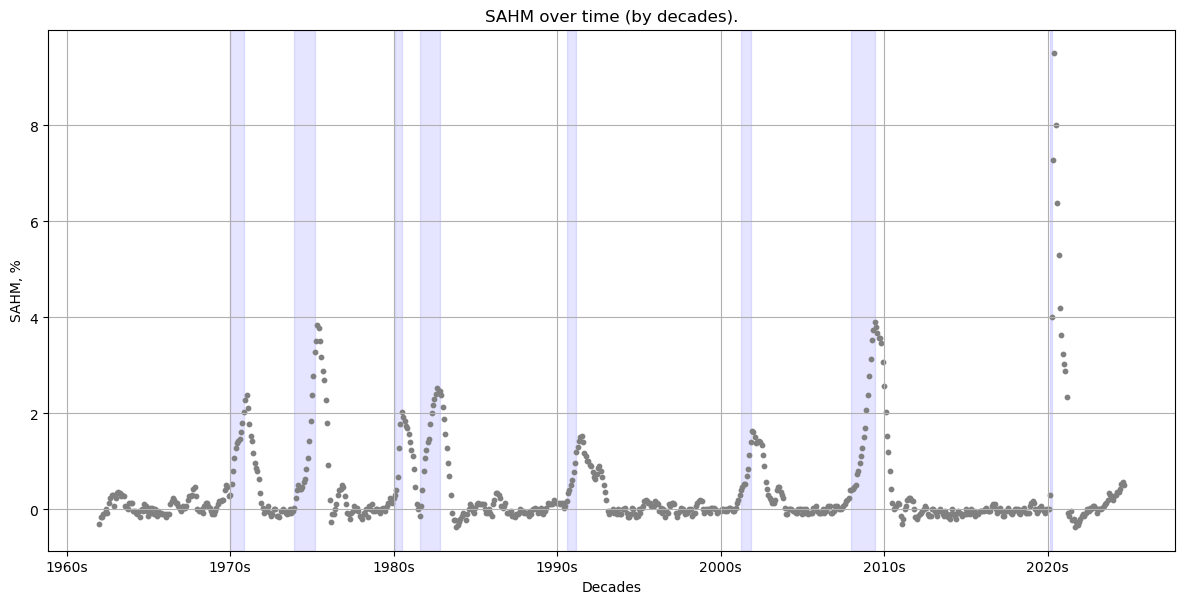

In [15]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
sahm['date'] = pd.to_datetime(sahm['date'])
plt.scatter(sahm['date'], sahm['sahm'], s=10, color='gray')  # s = the point size
# Readability settings.
plt.ylabel('SAHM, %')
plt.title('SAHM over time (by decades).')
plt.show()

2. **<a style="color:purple;">Industrial Production Index</a>** (INDPRO)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/INDPRO)** we download information for the period of our study: **Industrial Production Index (INDPRO)** [3], Seasonally Adjusted. Frequency: Monthly.

In [17]:
indpro = pd.read_csv('data/INDPRO.csv') # Read the CSV file
indpro.columns = ["date", "indpro"]

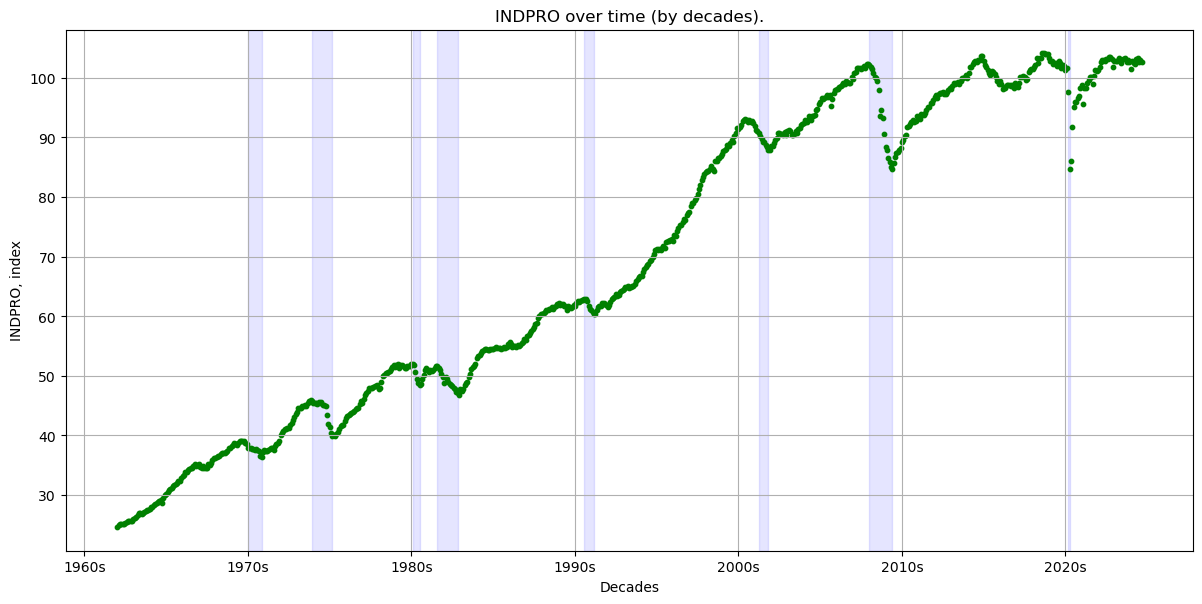

In [18]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
indpro['date'] = pd.to_datetime(indpro['date'])
plt.scatter(indpro['date'], indpro['indpro'], s=10, color='green')  # s = the point size
# Readability settings.
plt.ylabel('INDPRO, index')
plt.title('INDPRO over time (by decades).')
plt.show()

3. **<a style="color:purple;">S&P 500 Index</a>** (SP500)

From this site **[Stooq](https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m)** we download information for the period of our study: **S&P 500 Index (SP500)** [4], Frequency: Monthly. This is the only publicly available data for the S&P 500 Index, which contains information all the way back to 1962!

In [20]:
sp = pd.read_csv('data/SP500.csv') # Read the CSV file
# Keep only the required columns.
keep_col = ['Date', 'Close']
sp500 = sp[keep_col]
del sp
# Renaming columns.
sp500.columns = ['date', 'sp500']

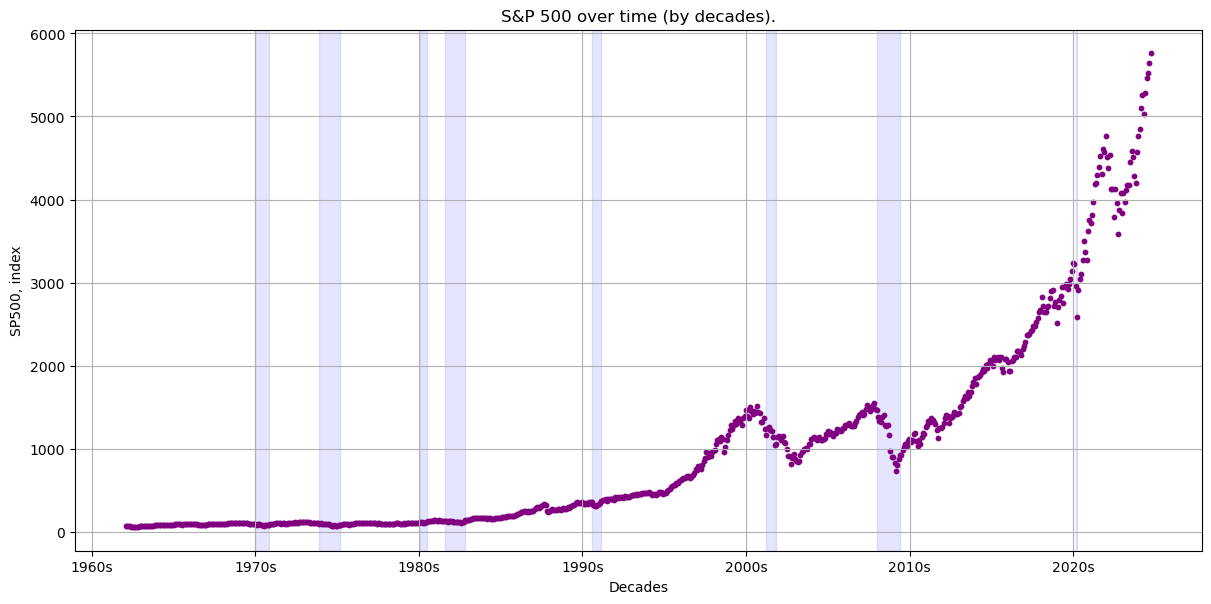

In [21]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
sp500['date'] = pd.to_datetime(sp500['date'])
plt.scatter(sp500['date'], sp500['sp500'], s=10, color='purple')  # s = the point size
# Readability settings.
plt.ylabel('SP500, index')
plt.title('S&P 500 over time (by decades).')
plt.show()

4. **<a style="color:purple;">10 year Treasury Bond</a>** (TR10)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/dgs10)** we download information for the period of our study: **10 year Treasury Bond** [5], Percent, Not Seasonally Adjusted. Frequency: **Daily**.

In [23]:
df = pd.read_csv('data/DGS10.csv') # Read the CSV file
df.columns = ["date", "tr10"]

In [24]:
# Replace '.' with NaN and convert column 'tr10' to numeric type.
df['tr10'] = pd.to_numeric(df['tr10'], errors='coerce')

# Group by month and calculate the arithmetic mean for each month.
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
monthly_avg = df.resample('MS').mean()

# Create a new dataframe with the first number of the month and the arithmetic mean.
tr10 = monthly_avg.reset_index()
del df

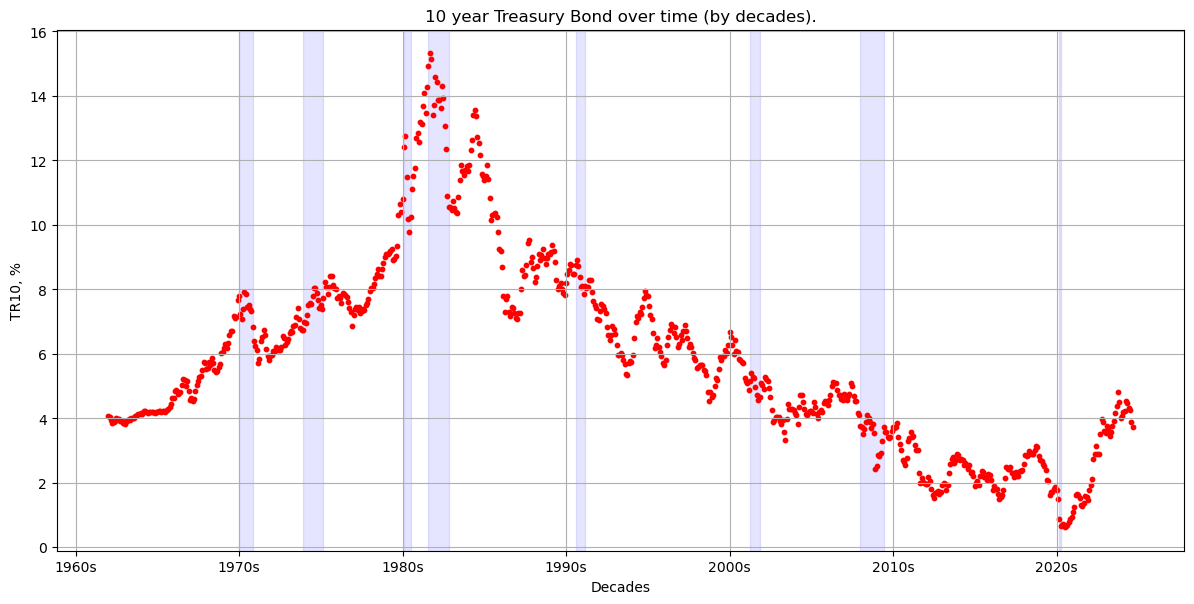

In [25]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
tr10['date'] = pd.to_datetime(tr10['date'])
plt.scatter(tr10['date'], tr10['tr10'], s=10, color='red')  # s = the point size
# Readability settings.
plt.xlabel('Decades')
plt.ylabel('TR10, %')
plt.title('10 year Treasury Bond over time (by decades).')
plt.show()

5. **<a style="color:purple;">Slope of the yield curve</a>** (T10YFF):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/T10YFF)** we download information for the period of our study: **Slope of the yield curve (T10YFF)**. [6]
Units: Percent, Seasonally Adjusted, Frequency: Monthly.

In [27]:
data = pd.read_csv('data/T10YFF.csv') # Read the CSV file
data.columns = ["date", "t10yff"]

In [28]:
# Replace '.' with NaN and convert column 't10yff' to numeric type.
data['t10yff'] = pd.to_numeric(data['t10yff'], errors='coerce')

# Group by month and calculate the arithmetic mean for each month.
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
monthly_avg = data.resample('MS').mean()

# Create a new dataframe with the first number of the month and the arithmetic mean.
t10yff = monthly_avg.reset_index()
del data

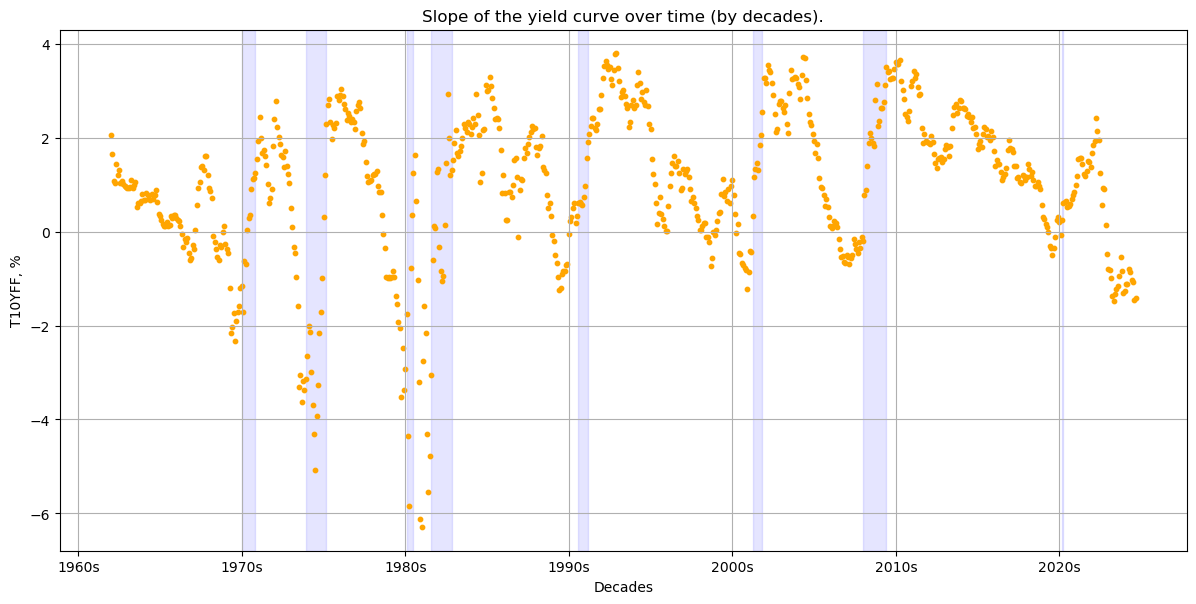

In [29]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
t10yff['date'] = pd.to_datetime(t10yff['date'])
plt.scatter(t10yff['date'], t10yff['t10yff'], s=10, color='orange')  # s = the point size
# Readability settings.
plt.ylabel('T10YFF, %')
plt.title('Slope of the yield curve over time (by decades).')
plt.show()

6. **<a style="color:purple;">Monthly Unemployment Rate</a>** (UNRATE):

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/UNRATE)** we download information for the period of our study: **Monthly Unemployment Rate (UNRATE)**. [7]
Units: Percent, Not Seasonally Adjusted. Frequency: Monthly.

In [31]:
unrate = pd.read_csv('data/UNRATE.csv') # Read the CSV file
unrate.columns = ["date", "unrate"]
# => Conversion from % to numbers !!
unrate["unrate"] = unrate["unrate"] / 100

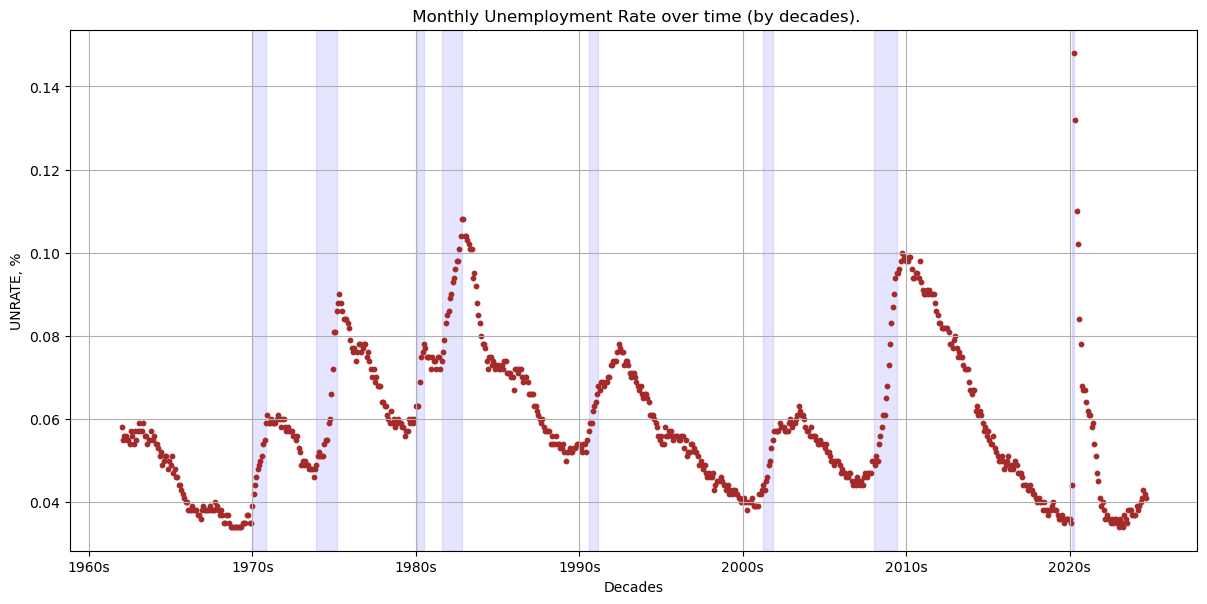

In [32]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
unrate['date'] = pd.to_datetime(unrate['date'])
plt.scatter(unrate['date'], unrate['unrate'], s=10, color='brown')  # s = the point size
# Readability settings.
plt.ylabel('UNRATE, %')
plt.title(' Monthly Unemployment Rate over time (by decades).')
plt.show()

7. **<a style="color:purple;">Personal Consumption Expenditures</a>** (PCEPI)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/PCEPI)** we download information for the period of our study: **Personal Consumption Expenditures (PCEPI)** [8], Seasonally Adjusted Annual Rate. Frequency: Monthly.

In [34]:
pcepi = pd.read_csv('data/PCEPI.csv') # Read the CSV file
pcepi.columns = ["date", "pcepi"]

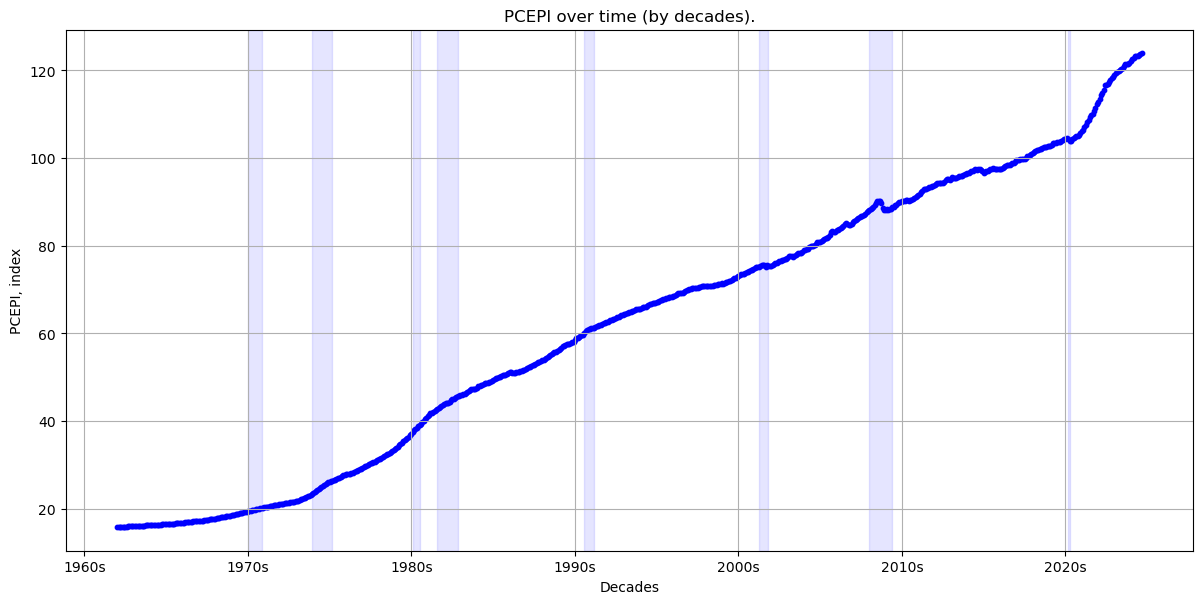

In [35]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
pcepi['date'] = pd.to_datetime(pcepi['date'])
plt.scatter(pcepi['date'], pcepi['pcepi'], s=10, color='blue')  # s = the point size
# Readability settings.
plt.ylabel('PCEPI, index')
plt.title('PCEPI over time (by decades).')
plt.show()

8. **<a style="color:purple;">Total Nonfarm Payroll</a>** (PAYEMS)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/PAYEMS)** we download information for the period of our study: **Total Nonfarm Payroll (PAYEMS)** [9], Units: Thousands of Persons, Seasonally Adjusted Annual Rate. Frequency: Monthly.

In [37]:
payems = pd.read_csv('data/PAYEMS.csv') # Read the CSV file
payems.columns = ["date", "payems"]

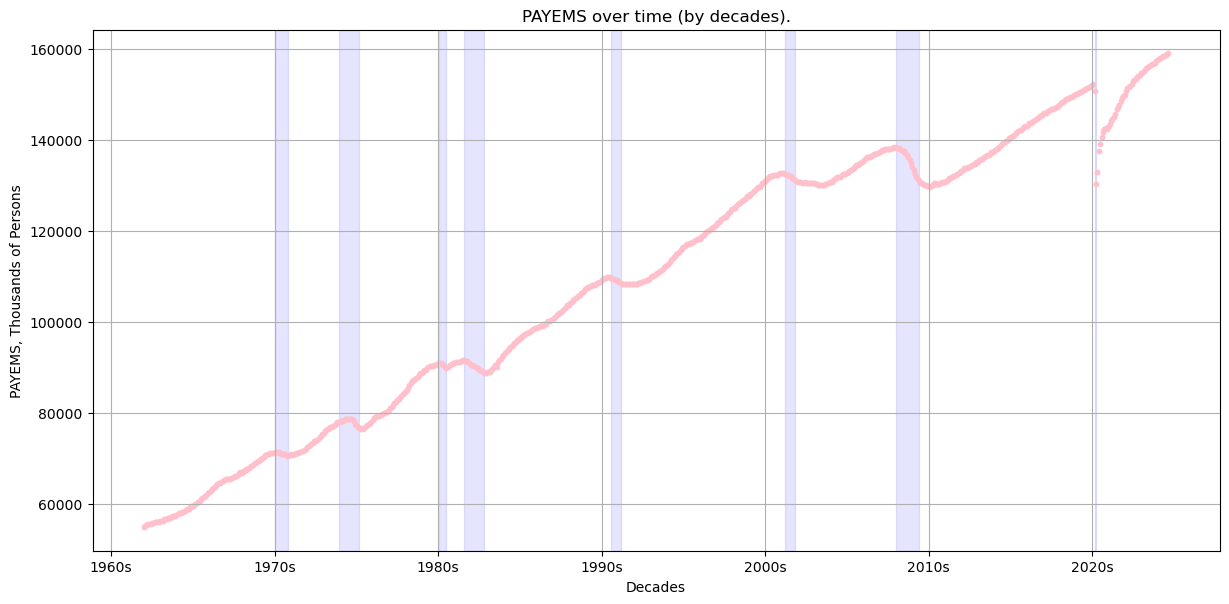

In [38]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
payems['date'] = pd.to_datetime(payems['date'])
plt.scatter(payems['date'], payems['payems'], s=10, color='pink')  # s = the point size
# Readability settings.
plt.ylabel('PAYEMS, Thousands of Persons')
plt.title('PAYEMS over time (by decades).')
plt.show()

9. **<a style="color:purple;"> New Privately-Owned Housing Units Started: Total Units</a>** (HOUST)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/HOUST)** we download information for the period of our study: **New Privately-Owned Housing Units Started: Total Units (HOUST)** [9], Units: Thousands of Units, Seasonally Adjusted Annual Rate. Frequency: Monthly.

In [40]:
houst = pd.read_csv('data/HOUST.csv') # Read the CSV file
houst.columns = ["date", "houst"]

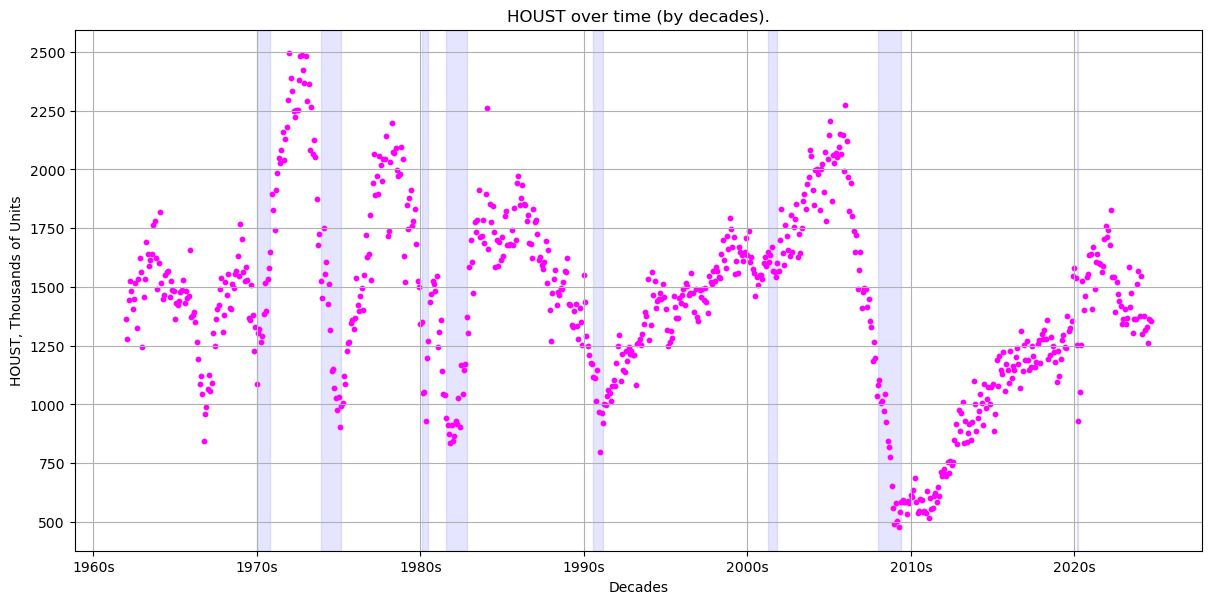

In [41]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
houst['date'] = pd.to_datetime(houst['date'])
plt.scatter(houst['date'], houst['houst'], s=10, color='magenta')  # s = the point size
# Readability settings.
plt.ylabel('HOUST, Thousands of Units')
plt.title('HOUST over time (by decades).')
plt.show()

10. **<a style="color:purple;">Historical Recessions Data.</a>**

With respect to the data collected above, I will **only consider data for recessions from 1962** to the present.

**How are recessions defined?**

The National Bureau of Economic Research (NBER) Business Cycle Dating Committee names “Peak” and “Trough” dates for business cycles. But there is a huge problem here:

    NBER declares “Peak” and “Trough” dates several months (sometimes years) after the fact!

This means one: cannot label outputs one period at a time! So to deploy a recession predictor of any sort, one must re-train the model at each formal NBER “trough” announcement (after each recession end). Therefore, one must also take this same approach during backtesting! [1]

**How do I label the class outputs?**

At first, this seems easy: **Recession = 1**, **No Recession = 0**. That is true, but is insufficient as it pertains to the desired model scope. To determine the labeling process, one must figure out the question being answered.

Is it: What is the probability that the U.S. will be in a recession X months from now?

If one wants to answer this question, one must forecast both the start and end of a recession. The model-predicted probabilities should start to drop before the recession actually ends. Needless to say, this is a pretty heroic task.

All months that are in a recessionary period will receive a label of “1”. All other months will receive a label of “0”.

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/USREC)** we download information for the period of our study: **NBER based Recession Indicators for the United States from the Period following the Peak through the Trough (USREC)**. [11] Unit: 1 or 0, Not Seasonally Adjusted. Frequency: Monthly.

In [44]:
recession = pd.read_csv('data/USREC.csv') # Read the CSV file
recession.columns = ["date", "recession"]

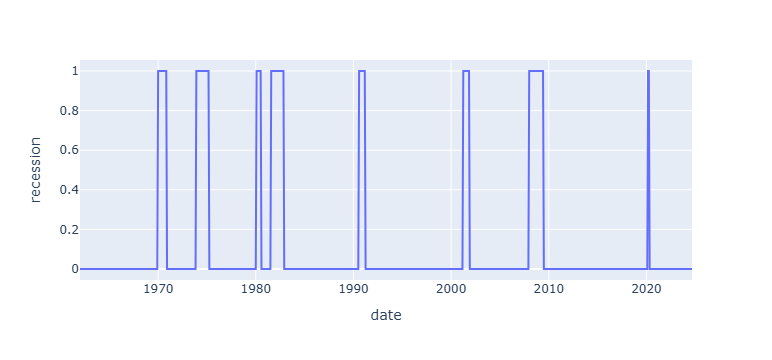

In [45]:
px.line(recession, x= recession.date, y='recession')

In [46]:
print("There are a total of {} months of recession in this data.".format(recession["recession"].sum()))

There are a total of 85 months of recession in this data.


11. **<a style="color:purple;">Preparation of consolidated data</a>**:
 - **Preprocessing, test of stationarity and cointegration**<br>

In [48]:
# Returns an array where each value is the logarithmic difference between the current
# and previous values ​​in the original array.
'''
    v.shift(1) => shifts the elements in the array down one position,
    with the first element becoming a NaN and the rest being moved forward one position.
    v/v.shift(1) => calculates the ratio of the current value to the previous value in the series.
    np.log(v/v.shift(1)) => calculates the natural logarithm (log to base e) of this ratio.
'''
def log_diff(v): 
    log_diff = np.log(v/v.shift(1))
    return log_diff

In [49]:
# Create a new empty table.
collected_data = pd.DataFrame(columns=[
    'sahm', # Real-time Sahm Rule Recession Indicator
    'indpro', # Industrial Production Index
    'sp500', # S&P 500 Index
    'tr10', # 10 year Treasury Bond
    't10yff', # Slope of the yield curve
    'unrate', # Unemployment Rate
    'pcepi', # Personal Consumption Expenditures
    'payems', # Total Nonfarm Payroll
    'houst', #  New Privately-Owned Housing Units Started
    'recession' # Recession Indicators
])
# Add data to the columns and preprocessing.
collected_data['sahm'] = sahm['sahm']
collected_data['t10yff'] = t10yff['t10yff']
collected_data['unrate'] = unrate['unrate']
collected_data['recession'] = recession['recession']
# Logarithmization is appropriate for series that have exponential growth or high variation.
collected_data['indpro'] = log_diff(indpro['indpro'])
# Logarithmization is appropriate for series that have exponential growth or high variation.
collected_data['sp500'] = log_diff(sp500['sp500'])
# TR10 has a clear trend (increasing or decreasing), differentiation can help.
collected_data['tr10'] = tr10['tr10'].diff()
# PCEPI has a clear trend (increasing or decreasing), differentiation can help.
collected_data['pcepi'] = pcepi['pcepi'].diff()
# PAYEMS has a clear trend (increasing or decreasing), differentiation can help.
collected_data['payems'] = payems['payems'].diff()
# Time series normalization due to large residuals.
# We create an instance of MinMaxScaler.
scaler = MinMaxScaler()
# We apply MinMaxScaler to the 'payems' column.
collected_data['payems'] = scaler.fit_transform(collected_data[['payems']])
# We apply MinMaxScaler to the 'houst' column.
collected_data['houst'] = houst['houst']
collected_data['houst'] = scaler.fit_transform(collected_data[['houst']])

In [50]:
# Drop missing values after preprocessing process.
len_before = len(collected_data)
collected_data.dropna(inplace=True)
len_after = len(collected_data)
print("Dropped {} rows".format(len_before - len_after))

Dropped 1 rows


Since the Spearman and Kendall heatmaps are practically the same, we only look at one of them.

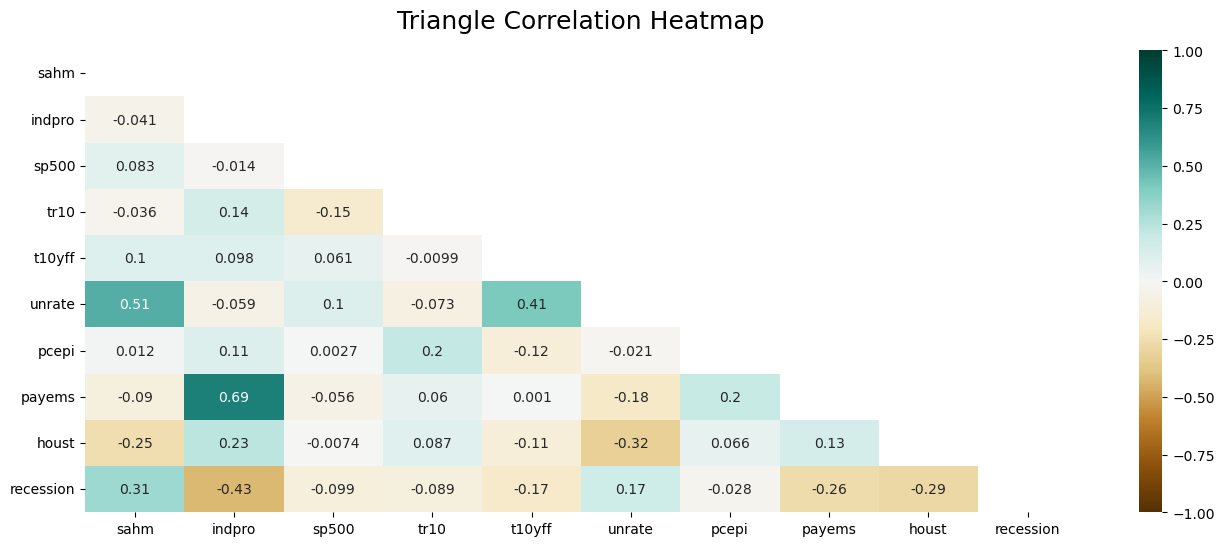

In [52]:
plt.figure(figsize=(16, 6)) # Determine the size of the figure.
# Define the mask to set the values ​​in the upper triangle to True.
mask = np.triu(np.ones_like(collected_data.corr(method='kendall'), dtype=bool))
heatmap = sns.heatmap(collected_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

Removing highly correlated features is a crucial preprocessing step in machine learning to improve model performance, interpretability, generalization, and computational efficiency. It helps create more robust and efficient models that are more suitable for real-world applications. [12]

In [54]:
# Create list of monthly dates.
dates = pd.date_range(start='02-1962', end='09-2024', freq='MS')
formatted_dates = pd.to_datetime(dates)

# Assuming collected_data is already an existing DataFrame with some data.
# Check the length of collected_data to ensure it matches the length of formatted_dates.
if len(collected_data) == len(formatted_dates):
    collected_data['date'] = formatted_dates
else:
    print("The length of collected_data does not match the length of formatted_dates!")
collected_data.set_index('date', inplace=True)

In [55]:
collected_data # _______ DataFrame (DF) with all data! _______

sahm    indpro     sp500      tr10    t10yff  unrate  pcepi  \
date                                                                      
1962-02-01 -0.17  0.016229  0.016139 -0.043737  1.650556   0.055  0.042   
1962-03-01 -0.17  0.005350 -0.005878 -0.108990  1.078182   0.056  0.021   
1962-04-01 -0.10  0.002130 -0.063973 -0.087455  1.043000   0.056  0.018   
1962-05-01 -0.07 -0.001066 -0.089914  0.030636  1.441818   0.055  0.010   
1962-06-01  0.00 -0.002132 -0.085381  0.035411  1.206667   0.055  0.010   
...          ...       ...       ...       ...       ...     ...    ...   
2024-05-01  0.37  0.006954  0.046904 -0.056818 -0.847727   0.040 -0.010   
2024-06-01  0.43  0.001500  0.034082 -0.177010 -1.024737   0.041  0.145   
2024-07-01  0.53 -0.006214  0.011258 -0.056627 -1.081364   0.043  0.202   
2024-08-01  0.57  0.003373  0.022578 -0.377727 -1.459091   0.042  0.142   
2024-09-01  0.50 -0.002832  0.019996 -0.147409 -1.406500   0.041  0.217   

              payems     houst  recession  
date                                       
1962-02-01  0.827913  0.396825          0  
1962-03-01  0.819544  0.478671          0  
1962-04-01  0.829109  0.518849          0  
1962-05-01  0.817113  0.498512          0  
1962-06-01  0.816714  0.459325          0  
...              ...       ...        ...  
2024-05-01  0.824685  0.415179          0  
2024-06-01  0.820780  0.422123          0  
2024-07-01  0.821816  0.388889          0  
2024-08-01  0.822414  0.437996          0  
2024-09-01  0.826200  0.434524          0  

[752 rows x 10 columns]

In [56]:
collected_data.to_csv(r'data/collected_data.csv') # We save the dataframe to a file.

To find out whether a time series is stationary or not, we use the Dickey-Fuller test.
From the **[calculations.ipynb](calculations.ipynb)** file, we collect data about the behavior of the time series in the following table:

<table>
  <caption>
    <b>Augmented Dickey-Fuller tests and conclusions</b>
  </caption>
  <thead style="background-color: purple; text-align: left">
    <tr>
      <th scope="col" style="color: white">Base indicator</th>
      <th scope="col" style="color: white">Index</th>
      <th scope="col" style="color: white">Conclusion</th>
    </tr>
  </thead>
  <tbody style="text-align: left">
      <tr>
      <th scope="row">Real-time Sahm Rule Recession Indicator</th>
      <td>SAHM</td>
      <td>stationary</td>
    </tr>
    <tr>
      <th scope="row">Industrial Production Index</th>
      <td>INDPRO</td>
      <td>stationary</td>
    </tr>
    <tr>
      <th scope="row">S&P 500 Index</th>
      <td>SP500</td> 
      <td>stationary</td>
    </tr>
    <tr>
      <th scope="row">10 year Treasury Bond</th>
      <td>TR10</td>
      <td>stationary</td>
    </tr>
    <tr>
      <th scope="row">Slope of the yield curve</th>
      <td>T10YFF</td>
      <td>stationary</td>
    <tr>
      <th scope="row">Monthly Unemployment Rate</th>
      <td>UNRATE</td>
      <td>stationary</td>
    </tr>
    <tr>
      <th scope="row">Personal Consumption Expenditures</th>
      <td>PCEPI</td>
      <td>stationary</td>
    </tr>
    <tr>
      <th scope="row">Total Nonfarm Payroll</th>
      <td>PAYEMS</td>
      <td>stationary</td>
    </tr>
    <tr>
      <th scope="row">New Privately-Owned Housing Units Started</th>
      <td>HOUST</td>
      <td>stationary</td>
    </tr>
  </tbody></table>

In [59]:
collected_data.describe().T

count      mean       std       min       25%       50%       75%  \
sahm       752.0  0.412527  0.984315 -0.370000 -0.030000  0.030000  0.370000   
indpro     752.0  0.001897  0.009524 -0.142045 -0.001726  0.002446  0.006304   
sp500      752.0  0.005887  0.043518 -0.245428 -0.017919  0.009800  0.034384   
tr10       752.0 -0.000478  0.277827 -1.755317 -0.145981 -0.002482  0.149554   
t10yff     752.0  0.982359  1.619839 -6.291905  0.118571  1.157828  2.181648   
unrate     752.0  0.058871  0.017200  0.034000  0.046000  0.056000  0.070000   
pcepi      752.0  0.143822  0.156321 -1.058000  0.057750  0.131000  0.209000   
payems     752.0  0.821600  0.032212  0.000000  0.818827  0.823410  0.826967   
houst      752.0  0.475000  0.192394  0.000000  0.358879  0.489087  0.584325   
recession  752.0  0.113032  0.316843  0.000000  0.000000  0.000000  0.000000   

                max  
sahm       9.500000  
indpro     0.063771  
sp500      0.151043  
tr10       1.612464  
t10yff     3.803636  
unrate     0.148000  
pcepi      1.089000  
payems     1.000000  
houst      1.000000  
recession  1.000000

Looks good!

### 3. **Modeling**
#### 3.1 Class Imbalance

First, we might ask our selves, how frequently do these recession months occur in the data?

In [62]:
c1 = collected_data["recession"].value_counts()[0]
c2 = collected_data["recession"].value_counts()[1]
print(collected_data["recession"].value_counts())
print("The minority class only makes up {} % ".format(round(c2/c1 * 100, 2)))

recession
0    667
1     85
Name: count, dtype: int64
The minority class only makes up 12.74 % 


<table>
  <thead style="background-color: purple; text-align: left">
    <tr>
      <th scope="col" style="color: white">Type of periods</th>
      <th scope="col" style="color: white">Start</th>
      <th scope="col" style="color: white">Stop</th>     
      <th scope="col" style="color: white">Recessions</th>
    </tr>
  </thead>
  <tbody style="text-align: left">
      <tr>
      <th scope="row">Train</th>
      <td>02.1962</td>
      <td>12.2012</td>
      <td>Yes, 7</td>
    </tr>
    <tr>
      <th scope="row">Test</th>
      <td>01.2013</td>
      <td>09.2024</td>
      <td>Yes, 1</td>
    </tr>
  </tbody></table>

So how can you handle class imbalances? We will **only use those classification models that deal well with unbalanced classes**.

Without a validation set, we will not be able to evaluate the performance of the model during training and tune the hyperparameters. Although the data is not much, creating new "synthetic" data (oversample using SMOTE) will not lead to precision in the final result. In view of the fact that we have few training records, **k-fold cross-validation** is the appropriate method. Usually k=5 is a good choice.

When dealing with imbalanced data, especially in a time series context, it is important to approach model estimation carefully. We evaluate the models on the validation set to get an idea of ​​their performance. We use metrics that are appropriate for unbalanced data, such as **F1-score**, **AUC**, **Precision**, and **Recall**, instead of just **Accuracy**. Even in the context of unbalanced data, precision is a more appropriate metric for evaluating model performance than accuracy.

#### 3.2 Modeling

The evaluation criteria, the **models and their settings** are described in the files: **[modeling_1.ipynb](modeling_1.ipynb)** and **[modeling_2.ipynb](modeling_2.ipynb)**.<br> Here we will only visualize the final result of the validation:

<table>
  <caption>Best models are: Random Forest, XGBoost and CatBoost</caption>
  <thead style="background-color: purple; text-align: left">
    <tr>
      <th scope="col" style="color: white">Model</th>
      <th scope="col" style="color: white">F1-score</th>
      <th scope="col" style="color: white">Precision</th>
      <th scope="col" style="color: white">Recall</th>
      <th scope="col" style="color: white">Accuracy</th>
    </tr>
  </thead>
  <tbody style="text-align: left">
    <tr>
      <th scope="row">Logistic Regression</th>
      <td>0.8024</td>
      <td>0.7976</td>
      <td>0.8072</td>
      <td>0.9460</td>
    </tr>
    <tr>
      <th scope="row">Decision Tree</th>
      <td>0.8075</td>
      <td>0.8333</td>
      <td>0.7831</td>
      <td>0.9493</td>
    </tr>
    <tr>
      <th scope="row">Random Forest</th>
      <td>0.8842</td>
      <td>0.8926</td>
      <td>0.8787</td>
      <td>0.9689</td>
    </tr>
    <tr>
      <th scope="row">XGBoost</th>
      <td>0.8557</td>
      <td>0.9267</td>
      <td>0.8088</td>
      <td>0.9657</td>
    </tr>
    <tr>
      <th scope="row">CatBoost</th>
      <td>0.8675</td>
      <td>0.8575</td>
      <td>0.9051</td>
      <td>0.9624</td>
    </tr>
    <tr>
      <th scope="row">SVM</th>
      <td>0.7677</td>
      <td>0.7810</td>
      <td>0.7978</td>
      <td>0.9330</td>
    </tr>
  </tbody></table>

**Analysis** based on model validation:

Based on overall performance, **Random Forest** is the best model, followed by **CatBoost** and **XGBoost**. **Decision Tree** and **Logistic Regression** also show good performance, but **<a style="color:purple;">SVM</a>** is the weakest model in all metrics. That's why <a style="color:purple;">it drops out when testing the models</a>.

##### 3.3 Testing the models

5 ML **models** should be **trained** and **tested**. AUC, F1-score, Precision, Recall, common confusion_matrix and Specificity will be calculated for each model. A ROC Curve plot will be drawn for the four models.

In [69]:
# get X and y 
X = collected_data.drop(['recession'], axis=1)
y = collected_data['recession']

# We define the training period.
X_train, y_train = X.loc["1962-02-01":"2012-12-01"], y.loc["1962-02-01":"2012-12-01"]
# We define the test period.
X_test, y_test = X.loc["2013-01-01":], y.loc["2013-01-01":]

Data form:
X_train shape: (601, 9)
X_test shape: (151, 9)
y_train shape: (601,)
y_test shape: (151,)

Distribution of classes:
Train class distribution:
recession
0    0.886855
1    0.113145
Name: proportion, dtype: float64

Test class distribution:
recession
0    0.887417
1    0.112583
Name: proportion, dtype: float64

Модел: Logistic Regression
Unique values ​​in predictions: [0 1]
Range of probabilities: 2.5377559223161707e-07 - 0.999983908938828
Confusion Matrix: TN=122, FP=12, FN=0, TP=17

Модел: Decision Tree
Unique values ​​in predictions: [0 1]
Range of probabilities: 0.0 - 1.0
Confusion Matrix: TN=130, FP=4, FN=2, TP=15

Модел: Random Forest
Unique values ​​in predictions: [0 1]
Range of probabilities: 0.0 - 0.9962633130021159
Confusion Matrix: TN=130, FP=4, FN=3, TP=14

Модел: XGBoost
Unique values ​​in predictions: [0 1]
Range of probabilities: 0.002605706 - 0.9757932
Confusion Matrix: TN=132, FP=2, FN=2, TP=15

Модел: CatBoost
Unique values ​​in predictions: [0 1]
Range of 

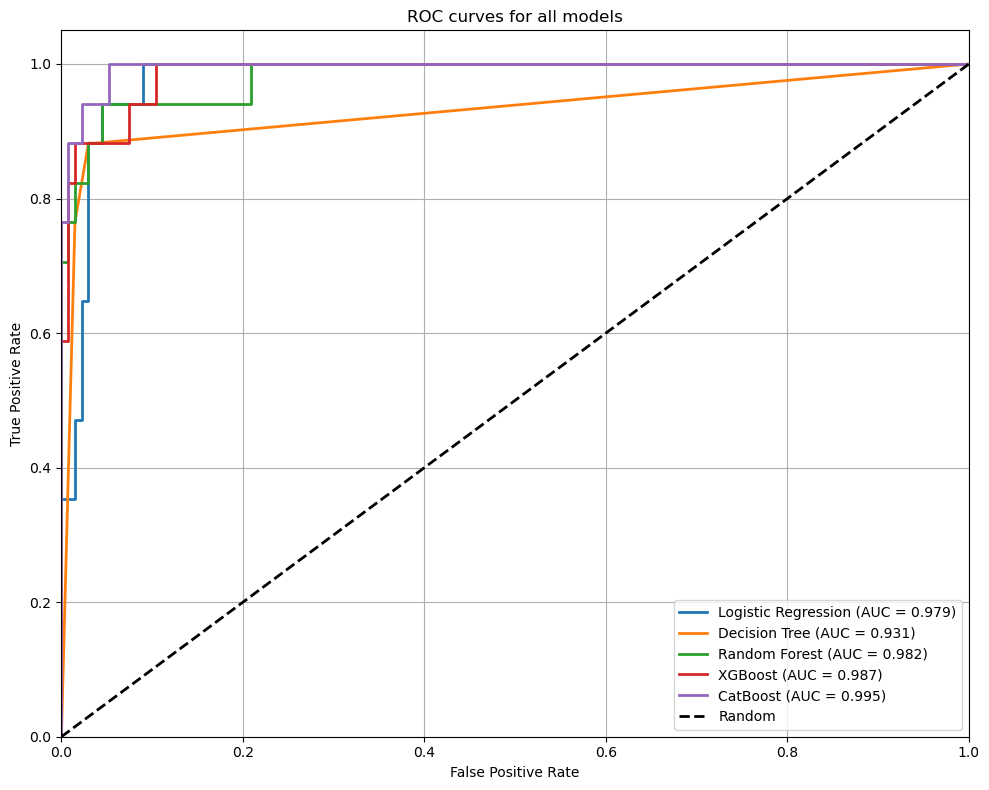


Metrics for all models:
                        AUC  F1-score  Precision  Recall  Specificity
Model                                                                
Logistic Regression  0.9794    0.7391     0.5862  1.0000       0.9104
Decision Tree        0.9306    0.8333     0.7895  0.8824       0.9701
Random Forest        0.9820    0.8000     0.7778  0.8235       0.9701
XGBoost              0.9868    0.8824     0.8824  0.8824       0.9851
CatBoost             0.9947    0.8649     0.8000  0.9412       0.9701


In [70]:
# Proper separation of data with stratification.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # This is the key change.
)

print("Data form:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nDistribution of classes:")
print("Train class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nTest class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

# Scaling the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Setting the graphics style.
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['axes.grid'] = True

# A function to calculate specificity.
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Initialization of models with their hyperparameters.
models = {
    'Logistic Regression': {
        'model': LogisticRegression(
            C=1,
            class_weight={0: 1, 1: 6},
            max_iter=1000,
            penalty='l2',
            solver='saga',
            random_state=42
        ),
        'needs_scaling': True
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(
            criterion='entropy',
            max_depth=5,
            max_features=None,
            min_samples_leaf=1,
            min_samples_split=2,
            random_state=42
        ),
        'needs_scaling': False
    },
    'Random Forest': {
        'model': RandomForestClassifier(
            bootstrap=False,
            class_weight='balanced',
            max_depth=15,
            max_features='sqrt',
            min_samples_leaf=4,
            min_samples_split=10,
            n_estimators=300,
            random_state=42
        ),
        'needs_scaling': False
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(
            colsample_bytree=0.9,
            gamma=0.1,
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=3,
            n_estimators=100,
            scale_pos_weight=1,
            subsample=1.0,
            random_state=42
        ),
        'needs_scaling': False
    },
    'CatBoost': {
        'model': CatBoostClassifier(
            auto_class_weights='Balanced',
            bagging_temperature=0,
            border_count=32,
            depth=8,
            iterations=200,
            l2_leaf_reg=1,
            learning_rate=0.05,
            random_strength=10,
            random_state=42,
            verbose=False
        ),
        'needs_scaling': False
    }
}

# List to store the results.
results = []
# Creating a figure for the ROC curves.
fig, ax = plt.subplots()

# Training and evaluation of models.
for name, model_info in models.items():
    model = model_info['model']
    needs_scaling = model_info['needs_scaling']
    
    # Choosing the right data according to the scaling need.
    X_train_data = X_train_scaled if needs_scaling else X_train
    X_test_data = X_test_scaled if needs_scaling else X_test
    
    try:
        # Training the model.
        model.fit(X_train_data, y_train)
        
        # Predictions:
        y_pred = model.predict(X_test_data)
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
        
        # Checking predictions.
        print(f"\nМодел: {name}")
        print("Unique values ​​in predictions:", np.unique(y_pred))
        print("Range of probabilities:", np.min(y_pred_proba), "-", np.max(y_pred_proba))
        
        # Confusion matrix:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
        
        # Calculating metrics:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Save metrics.
        results.append({
            'Model': name,
            'AUC': roc_auc,
            'F1-score': f1_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Specificity': specificity_score(y_test, y_pred)
        })
        
        # Add ROC curve.
        ax.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
        
    except Exception as e:
        print(f"Error at {name}: {str(e)}")

# Finalizing the ROC plot.
ax.plot([0, 1], [0, 1], 'k--', label='Random', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curves for all models')
ax.legend(loc="lower right")
ax.grid(True)
plt.tight_layout()
plt.show()

# Create a DataFrame with the results.
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')
print("\nMetrics for all models:")
print(results_df.round(4).to_string())

**F1-scores are balanced**. Most models reach 0.8824. Decision Tree is slightly weaker at 0.8333. Logistic Regression is weakest at 0.7727.

**Precision** and **Recall** are balanced for most models (0.8824), which is a good sign. **Specificity** was high for all models (>0.92), indicating good recognition of negative cases.

We have to choose a best model:

**<a style="color:purple;">CatBoost</a>** seems to be the best choice with the highest AUC.
**<a style="color:purple;">XGBoost</a>** and **<a style="color:purple;">Random Forest</a>** are very close to it in terms of performance.
<a style="color:purple;">All **three have the same metrics**</a> for F1-score, Precision, Recall and Specificity. Finding the best model or models in this case can hardly be done just by the numbers. Let's see how the models behave in "real time" around the time of economic recession. The behavior of the models is graphically depicted. We also have 3 recessionary periods in the form of light blue columns.

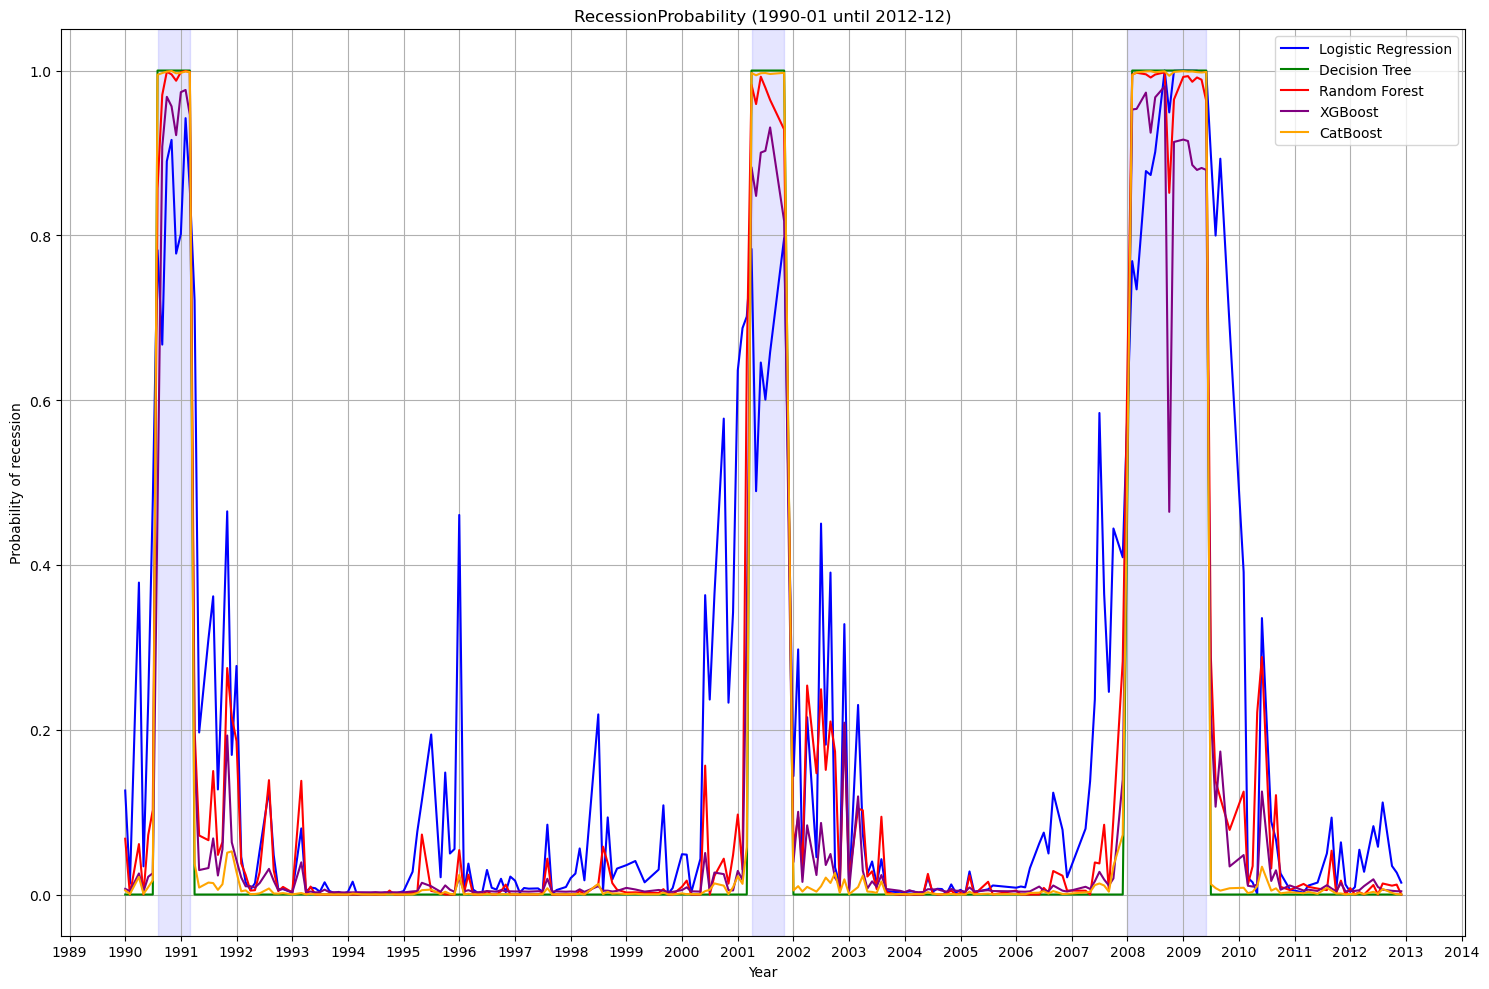

In [72]:
# We create a DataFrame with predictions using the X_train index.
predictions_df = pd.DataFrame(index=X_train.index)
# We add the predictions from each model.
for name, model_info in models.items():
    model = model_info['model']
    needs_scaling = model_info['needs_scaling']
    
    X_data = X_train_scaled if needs_scaling else X_train
    predictions = model.predict_proba(X_data)[:, 1]
    
    predictions_df[name] = predictions

# We sort the index to ensure it is monotonic.
predictions_df = predictions_df.sort_index()

# We find the closest date to the beginning and end of the desired period.
start_date = predictions_df.index[predictions_df.index >= '1990-01-01'].min()
end_date = predictions_df.index[predictions_df.index <= '2012-12-31'].max()

# We filter the data only for the period 1990-2012.
predictions_df = predictions_df.loc[start_date:end_date]

# We create the graphic.
plt.figure(figsize=(15, 10))
# Colors for every model.
colors = ['blue', 'green', 'red', 'purple', 'orange']

# We visualize the predictions for each model.
for (name, color) in zip(models.keys(), colors):
    plt.plot(predictions_df.index, predictions_df[name], color=color, label=name)

# We add vertical columns for the specific periods.
periods = [
    ('1990-08-01', '1991-03-01'),
    ('2001-04-01', '2001-11-01'),
    ('2008-01-01', '2009-06-01')
]

for start, end in periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='blue', alpha=0.1)

plt.title(f'RecessionProbability ({start_date.strftime("%Y-%m")} until {end_date.strftime("%Y-%m")})')
plt.xlabel('Year')
plt.ylabel('Probability of recession')
plt.legend()
plt.grid(True)

# Format x-axis to show only years.
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.tight_layout()

plt.show()

The "cleanest" is the Decision Tree model, but here we only have 3 recession periods depicted. It is followed by the <a style="color:purple;">**CatBoost**</a> model. The latter performs **best as numerical metrics**, so it is <a style="color:purple;">**chosen as the model that will predict**</a> future economic recession.

### 4. **Final forecast**

#### 4.1 **First way** to forecast.

Let's start calculating the probability of the US going into recession now.

In [74]:
collected_data = pd.read_csv('data/collected_data.csv') # Read the CSV file
data = collected_data.copy()
# Setting column 'date' as index.
data = data.set_index('date', drop=True)
# get X and y 
X = data.drop(['recession'], axis=1)
y = data['recession']

In [75]:
# We define the training period.
X_train, y_train = X.loc["1962-02-01":"2012-12-01"], y.loc["1962-02-01":"2012-12-01"]
# We define the test period.
X_test, y_test = X.loc["2013-01-01":], y.loc["2013-01-01":]

# Building and training the model.
cb_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    iterations=200,
    depth=8,
    learning_rate=0.05,
    random_state=42,
    verbose=False
)

# Training the model.
cb_model.fit(X_train, y_train)

# Using the prediction model.
predictions = cb_model.predict(X_test)

# Recession probabilities (ie, how likely a recession is 6 months from now).
probabilities = cb_model.predict_proba(X_test)[:, 1]  # Probability of Class "1" (Recession)

Accuracy: 0.9645
Precision: 0.2857
Recall: 1.0000
F1 Score: 0.4444
ROC AUC: 0.9928

Confusion Matrix:
[[134   5]
 [  0   2]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       139
           1       0.29      1.00      0.44         2

    accuracy                           0.96       141
   macro avg       0.64      0.98      0.71       141
weighted avg       0.99      0.96      0.97       141



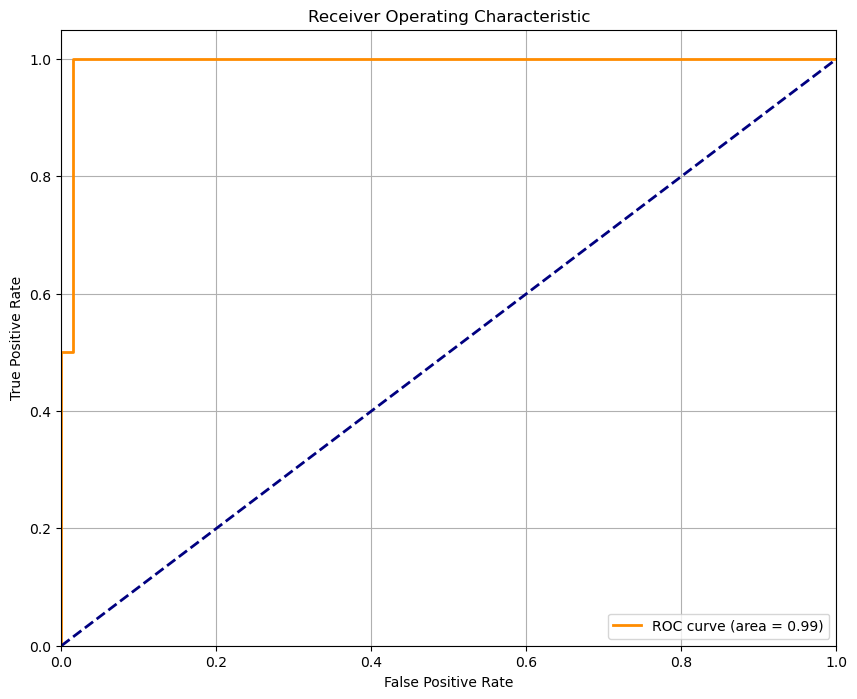

In [76]:
# Model evaluation:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\nClassification Report:")
print(classification_report(y_test, predictions))

# ROC curve visualization.
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [77]:
# We use the latest available data (for example, the last 6 months).
# This will be our current "input" for the model to make a forecast 6 months ahead.
latest_data = X.tail(6)  # We take the last 6 months of available data.

# We predict the probability of a recession 6 months ahead.
future_probabilities = cb_model.predict_proba(latest_data)[:, 1]  # Probability of class "1" (recession).

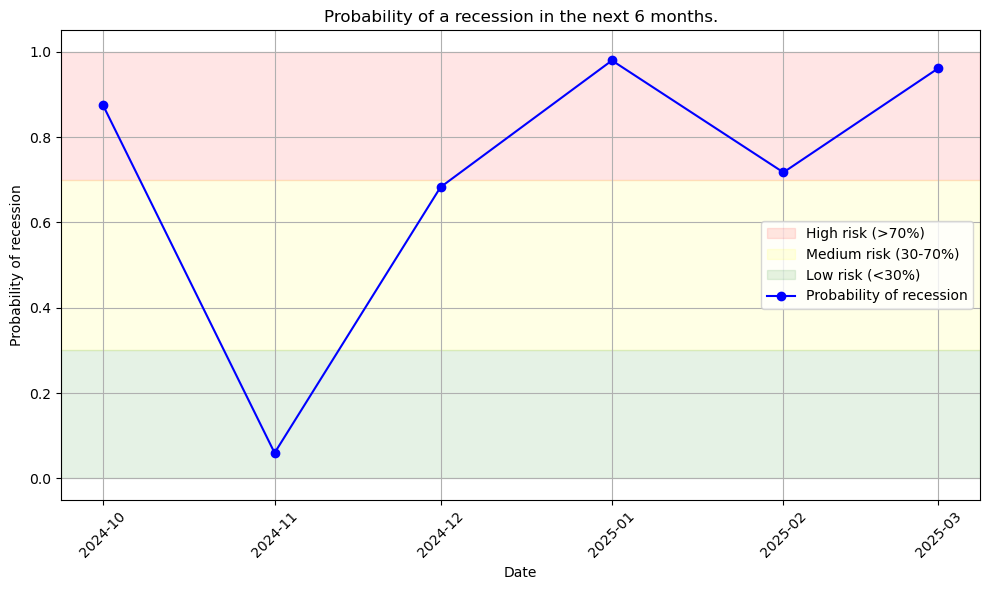

probability_of_recession
date                                
2024-10-01                  0.873895
2024-11-01                  0.059752
2024-12-01                  0.682443
2025-01-01                  0.979363
2025-02-01                  0.717093
2025-03-01                  0.961044

In [78]:
# We create the correct future dates starting from October 2024.
start_date = pd.Timestamp('2024-10-01')
future_dates = pd.date_range(start=start_date, periods=6, freq='MS')  # MS means start of month.

# Visualization of the likelihood of a recession in the next 6 months.
plt.figure(figsize=(10, 6))

# We are adding color zones for the different risk levels.
plt.axhspan(0.7, 1.0, color='red', alpha=0.1, label='High risk (>70%)')
plt.axhspan(0.3, 0.7, color='yellow', alpha=0.1, label='Medium risk (30-70%)')
plt.axhspan(0, 0.3, color='green', alpha=0.1, label='Low risk (<30%)')

plt.plot(future_dates, future_probabilities, marker='o', linestyle='-', color='b', label='Probability of recession')

# Format x-axis dates.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date')
plt.ylabel('Probability of recession')
plt.title('Probability of a recession in the next 6 months.')
plt.xticks(future_dates, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Probability of a recession in the next months.
future_prob_df = pd.DataFrame({
    'date': future_dates,
    'probability_of_recession': future_probabilities
})
future_prob_df.set_index('date', inplace=True)

future_prob_df

In [79]:
# Probability of recession => as arithmetic mean of probabilities for all months.
average_probability = (future_prob_df['probability_of_recession'].mean() * 100).round(2)
formatted_probability = f"{average_probability} %"
print(">>> ------ >> ----- > ----")
print(f"Average probability of a recession over the entire period: {formatted_probability}")

>>> ------ >> ----- > ----
Average probability of a recession over the entire period: 71.23 %


Have we solved the task yet? Not quite. Let's check with another way to predict.

#### 4.2 **Second way** of prediction.

Here we use a method to predict each feature using **ARIMA**. Thus, after for each 1 economic indicator we predict its behavior for another 6 months, we collect everything again in a whole dataframe and run the model again. It will have the added information for its own and we can easily visualize the value of the target variable: recession.

In time series analysis used in statistics and econometrics, **autoregressive integrated moving average (ARIMA)** and seasonal ARIMA (SARIMA) models are generalizations of the autoregressive moving average (ARMA) model to non-stationary series and periodic variation, respectively. All these models are fitted to time series in order to better understand it and predict future values. The purpose of these generalizations is to fit the data as well as possible. Specifically, ARMA assumes that the series is stationary, that is, its expected value is constant in time. If instead the series has a trend (but a constant variance/autocovariance), the trend is removed by "differencing", leaving a stationary series. This operation generalizes ARMA and corresponds to the "integrated" part of ARIMA. [13]

The code for the ARIMA settings and the process of generating the new data can be seen in this file: **[ARIMA.ipynb](ARIMA.ipynb)**

We extract the new dataframe with the new data added, ARIMA prediction:

In [81]:
new_data = pd.read_csv('data/combined_data.csv') # We read the CSV file with the newly generated data.
# Setting column 'Unnamed: 0' as index.
new_data = new_data.rename(columns={'Unnamed: 0': 'date'})
# We make the 'date' column an ​​index.
new_data = new_data.set_index('date')

new_data

sahm    indpro     sp500      tr10    t10yff    unrate  \
date                                                                     
1962-02-01 -0.170000  0.016229  0.016139 -0.043737  1.650556  0.055000   
1962-03-01 -0.170000  0.005350 -0.005878 -0.108990  1.078182  0.056000   
1962-04-01 -0.100000  0.002130 -0.063973 -0.087455  1.043000  0.056000   
1962-05-01 -0.070000 -0.001066 -0.089914  0.030636  1.441818  0.055000   
1962-06-01  0.000000 -0.002132 -0.085381  0.035411  1.206667  0.055000   
...              ...       ...       ...       ...       ...       ...   
2024-11-01  0.371263  0.001896 -0.000628  0.000468 -1.054334  0.042184   
2024-12-01  0.365931  0.001896  0.012222 -0.000439 -0.907669  0.042725   
2025-01-01  0.369188  0.001896 -0.000270 -0.000439 -0.771676  0.043291   
2025-02-01  0.373684  0.001896  0.011875 -0.000439 -0.645579  0.043803   
2025-03-01  0.377939  0.001896  0.000068 -0.000439 -0.528658  0.044322   

               pcepi    payems     houst  recession  
date                                                 
1962-02-01  0.042000  0.827913  0.396825          0  
1962-03-01  0.021000  0.819544  0.478671          0  
1962-04-01  0.018000  0.829109  0.518849          0  
1962-05-01  0.010000  0.817113  0.498512          0  
1962-06-01  0.010000  0.816714  0.459325          0  
...              ...       ...       ...        ...  
2024-11-01  0.199241  0.820944  0.434200          0  
2024-12-01  0.196893  0.821594  0.430898          0  
2025-01-01  0.194642  0.821594  0.435397          0  
2025-02-01  0.192485  0.821594  0.432419          0  
2025-03-01  0.190417  0.821594  0.436556          0  

[758 rows x 10 columns]

We train the model on the new dataframe and test it on the new test set containing the generated new 6 months.

In [83]:
# get X and y 
X = new_data.drop(['recession'], axis=1)
y = new_data['recession']

# We define the training period.
X_train, y_train = X.loc["1962-02-01":"2012-12-01"], y.loc["1962-02-01":"2012-12-01"]
# We define the test period.
X_test, y_test = X.loc["2013-01-01":], y.loc["2013-01-01":]

# Building and training the model.
new_cb_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    iterations=200,
    depth=8,
    learning_rate=0.05,
    random_state=42,
    verbose=False
)

# Training the model.
new_cb_model.fit(X_train, y_train)

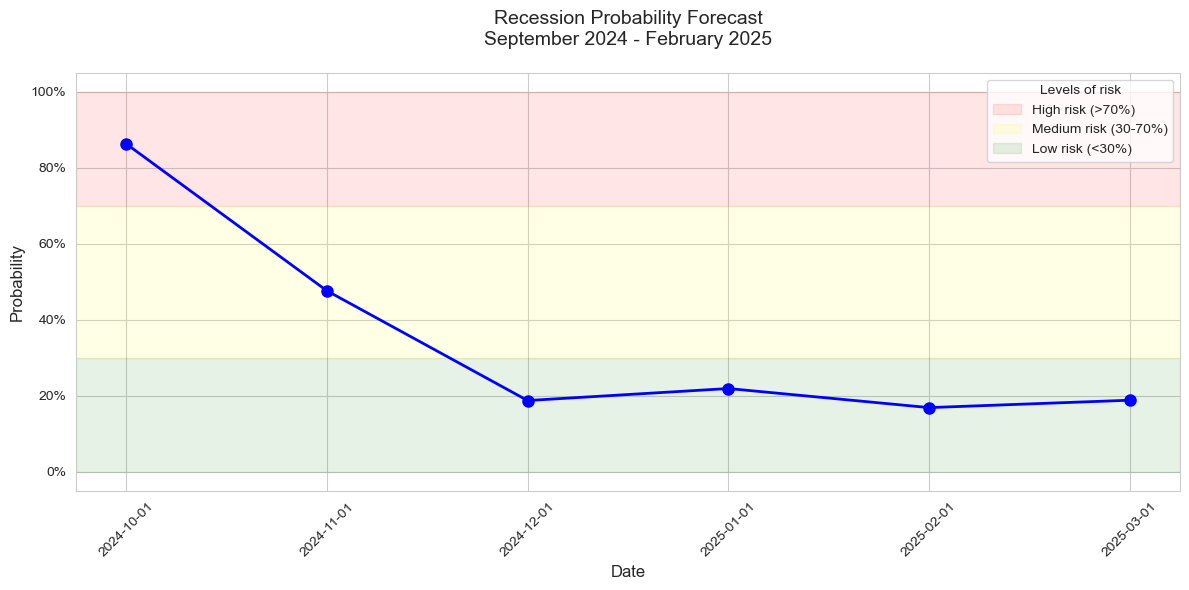

Date  Recession Probability
141  2024-10-01               0.862716
142  2024-11-01               0.476150
143  2024-12-01               0.187531
144  2025-01-01               0.219110
145  2025-02-01               0.168936
146  2025-03-01               0.188394

In [154]:
# We make predictions for the entire test period.
all_probabilities = new_cb_model.predict_proba(X_test)[:, 1]

# We create a DataFrame with all predictions.
full_results_df = pd.DataFrame({
    'Date': X_test.index,
    'Recession Probability': all_probabilities
})

# We only take the last 6 months for preview.
results_df = full_results_df.tail(6)

# We create the visualization.
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(results_df['Date'], results_df['Recession Probability'], 
         marker='o', linewidth=2, markersize=8, color='blue')

# We are adding color zones for the different risk levels.
plt.axhspan(0.7, 1.0, color='red', alpha=0.1, label='High risk (>70%)')
plt.axhspan(0.3, 0.7, color='yellow', alpha=0.1, label='Medium risk (30-70%)')
plt.axhspan(0, 0.3, color='green', alpha=0.1, label='Low risk (<30%)')

# Chart formatting.
plt.title('Recession Probability Forecast\nSeptember 2024 - February 2025', 
          fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Probability', fontsize=12)

# Format the y-axis as a percentage.
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
# Date rotation.
plt.xticks(rotation=45)
plt.legend(loc='upper right', title='Levels of risk')

# We add annotations with the exact values.
for idx, row in results_df.iterrows():
    plt.annotate(f'{row["Recession Probability"]:.1%}',
                (idx, row["Recession Probability"]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontweight='bold')

# We set the borders of the graph.
plt.ylim(-0.05, 1.05)
# Layout optimization.
plt.tight_layout()
plt.show()

results_df

In [85]:
# Probability of recession => as arithmetic mean of probabilities for all months.
avg_probability = (results_df['Recession Probability'].mean() * 100).round(2)
f_probability = f"{avg_probability} %"
print(">>> ------ >> ----- > ----")
print(f"Average probability of a recession over the entire period: {f_probability}")

>>> ------ >> ----- > ----
Average probability of a recession over the entire period: 35.05 %


The **first method** works on the following principle:

 - Takes the last 6 months of real data.
 - Directly applies a trained model to this data to predict the probability of a recession for each of these months.
 - It does not try to predict future feature values, but works with the last known values.
 - cb_model.predict_proba(latest_data) calculates the probability of a recession occurring in the future based on the most recently observed economic indicators.
 - Fictitious future dates for the next 6 months are generated so that the model can predict the probability of a recession for each of them.

The **second method** (with ARIMA) is probably less reliable because:

 - Includes two stages of prediction, which increases the potential error.
 - ARIMA predictions 6 months ahead can be inaccurate, especially in volatile economic conditions.
 - Errors from ARIMA predictions are carried over to the final model.

The **first method is more reliable** because:

 - Works directly with real data.
 - There is only one stage of prediction.
 - Less likely to accumulate errors.
 - A more conservative approach that relies on current economic indicators.

However, the best approach would be to use both methods in parallel and compare the results, as each can capture different aspects of the economic situation.

#### 4.3 **Third Way** of Forecasting.

It uses a **<a style="color:purple;">Rolling Window Approach</a>** that:

 - It captures changes in economic interrelationships over time.
 - Accounts for local trends and volatility.
 - Better adapts to changing economic conditions.

Adds new features based on historical data:

 - Trend in the data.
 - Volatility.
 - Momentum (rate of change).

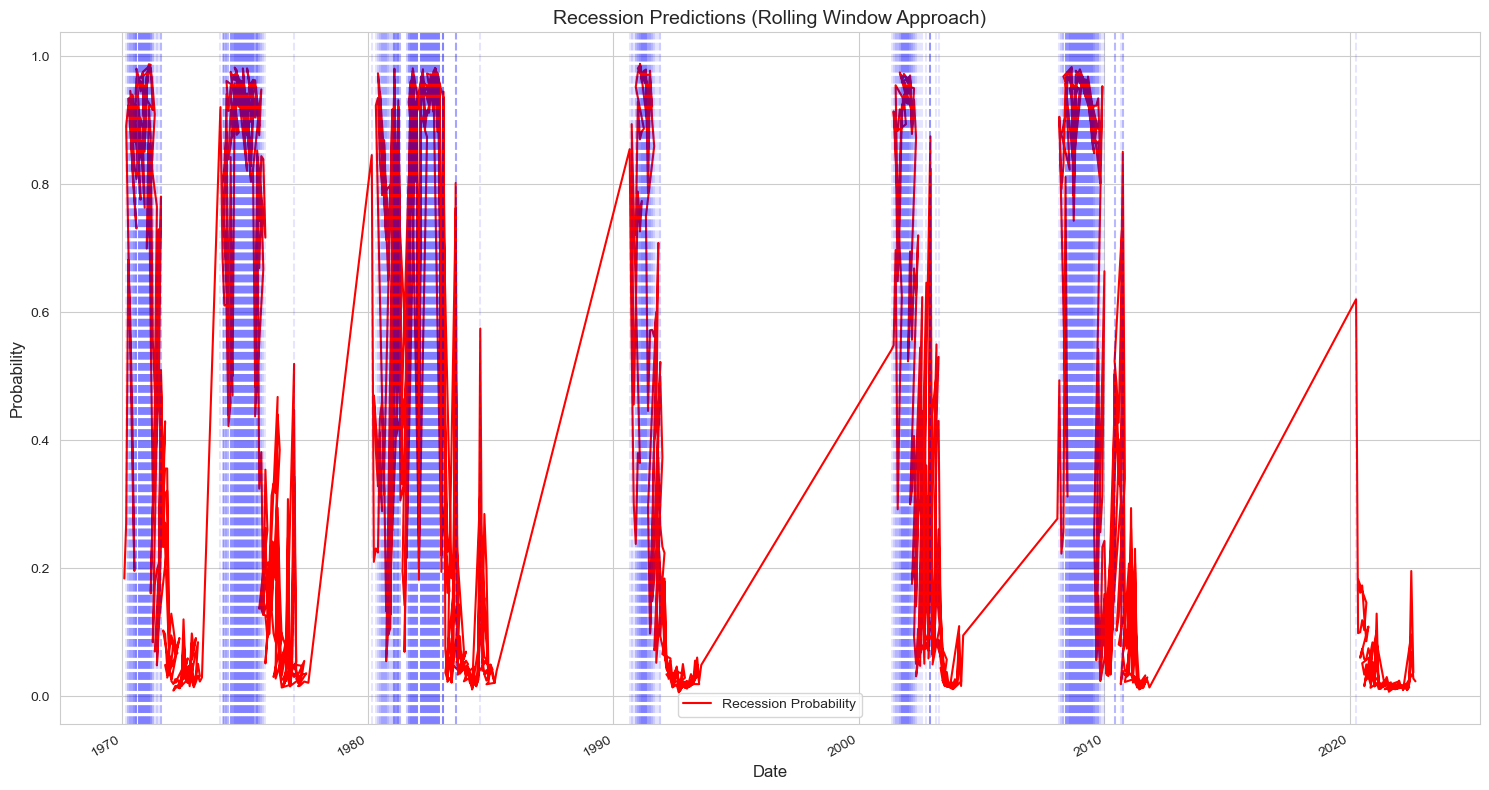

In [88]:
def rolling_window_prediction(df, features, target, model, window_size=24, prediction_horizon=6):
    """
    Rolling window approach for recession prediction.
    
    Parameters:
    df : pandas DataFrame
        Input data with features and target variable.
    features : list
        List of feature names.
    target : str
        Target variable (e.g., 'recession').
    model : sklearn-like model
        Model to be trained and used for predictions.
    window_size : int
        Size of the rolling window for training (in months).
    prediction_horizon : int
        Number of months to predict ahead.
    
    Returns:
    pandas DataFrame
        Results with dates, predicted probabilities, and risk levels.
    """
    predictions = []
    probabilities = []
    dates = []
    
    for i in range(len(df) - window_size - prediction_horizon + 1):
        # Define training and future windows
        train_window = df.iloc[i:i + window_size]
        future_window = df.iloc[i + window_size:i + window_size + prediction_horizon]
        
        # Train model on the rolling window
        X_train = train_window[features]
        y_train = train_window[target]
        
        # Skip windows where the target has only one unique value
        if y_train.nunique() <= 1:
            continue
        
        model.fit(X_train, y_train)
        
        # Predict on future window
        X_future = future_window[features]
        pred = model.predict(X_future)
        prob = model.predict_proba(X_future)[:, 1]
        
        predictions.extend(pred)
        probabilities.extend(prob)
        dates.extend(future_window.index)
    
    # Create a results DataFrame
    results = pd.DataFrame({
        'date': dates,
        'predicted_recession': predictions,
        'recession_probability': probabilities
    }).set_index('date')
    
    # Add risk levels
    results['risk_level'] = pd.cut(results['recession_probability'], 
                                   bins=[0, 0.3, 0.6, 1], 
                                   labels=['Low', 'Medium', 'High'])
    return results

# Load and prepare data
data = pd.read_csv('data/collected_data.csv').set_index('date')
data.index = pd.to_datetime(data.index)

# Define features and target
features = [col for col in data.columns if col != 'recession']
target = 'recession'

# Create the model
cboost_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    iterations=200,
    depth=8,
    learning_rate=0.05,
    random_state=42,
    verbose=False
)

# Use rolling window prediction
results = rolling_window_prediction(data, features, target, cboost_model, window_size=24, prediction_horizon=6)

# Visualize results
fig, ax = plt.subplots(figsize=(15, 8))
results['recession_probability'].plot(ax=ax, label='Recession Probability', color='red')
results[results['predicted_recession'] == 1].index.map(
    lambda x: ax.axvline(x=x, color='blue', linestyle='--', alpha=0.1, label='Predicted Recession' if x == results.index[0] else "")
)
ax.set_title('Recession Predictions (Rolling Window Approach)', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

After window_size=24, the result that is obtained is almost independent of its size, measured in months.<br>
The **Rolling Window Approach** method for predicting economic recession **works, but if we have classical economics**.<br>
Which does not evolve from "bright to brighter future" with the help of massive money infusions and thus avoiding recessions. When recognized economic recessions over large periods are very small or absent, then the model apparently does not do well. That is why **it is not included in the final stage** of the study.

We create **an ensemble of the two methods** and obtain the summary below.<br>
Because of the possible errors of the second method, we give it a weight of 0.3. The first method receive a weight of 0.7.<br>
It does not claim to be faithful, it is simply **<a style="color:purple;">an attempt to summarize the results</a>** of the entire study.

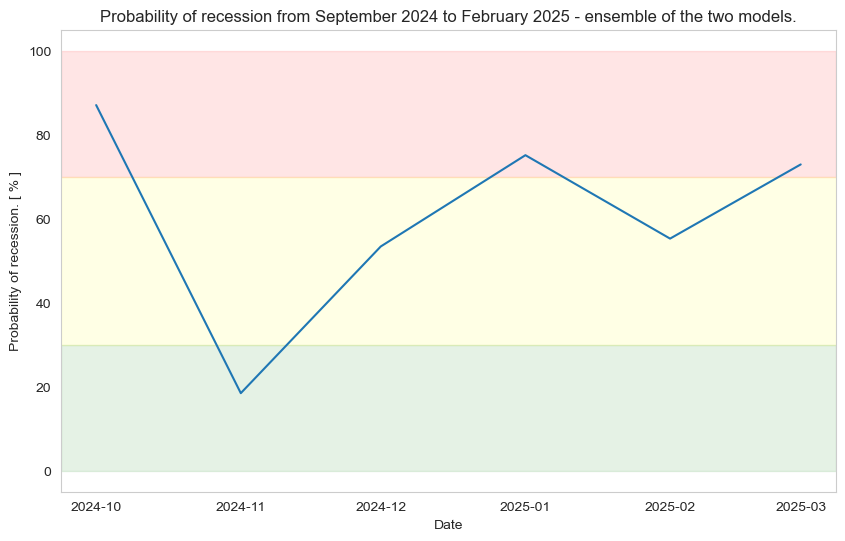

Recession Probability
2024-10-01              87.054083
2024-11-01              18.467138
2024-12-01              53.396982
2025-01-01              75.128673
2025-02-01              55.264570
2025-03-01              72.924928

In [91]:
# Parameters for the new DataFrame.
dates = pd.date_range(start='2024-10-01', end='2025-03-01', freq='MS')  # Monthly index

# Calculating the probability of a recession by taking only the last 6 values.
recession_probabilities = (
    future_prob_df['probability_of_recession'].iloc[-6:].values * 0.7 * 100 + 
    results_df['Recession Probability'].iloc[-6:].values * 0.3 * 100
)

# Create the new DataFrame.
new_df = pd.DataFrame(data=recession_probabilities, index=dates, columns=['Recession Probability'])

# Create a graph of the probability of a recession.
plt.figure(figsize=(10, 6))
plt.plot(new_df.index, new_df['Recession Probability'])
plt.title('Probability of recession from September 2024 to February 2025 - ensemble of the two models.')

# We are adding color zones for the different risk levels.
plt.axhspan(70, 100, color='red', alpha=0.1, label='High risk (>70%)')
plt.axhspan(30, 70, color='yellow', alpha=0.1, label='Medium risk (30-70%)')
plt.axhspan(0, 30, color='green', alpha=0.1, label='Low risk (<30%)')

plt.xlabel('Date')
plt.ylabel('Probability of recession. [ % ]')
plt.grid()
plt.show()

new_df

In [92]:
# Probability of recession => as arithmetic mean of probabilities for all months.
avg_probability = (new_df['Recession Probability'].mean()).round(2)
f_probability = f"{avg_probability} %"
print(">>> ------ >> ----- > ----")
print("Average recession probability of the ensemble of the three methods over the entire period: ", f_probability)

>>> ------ >> ----- > ----
Average recession probability of the ensemble of the three methods over the entire period:  60.37 %


**![Cute polar bear](data/polar_bear.png)** <br>Cute polar bear saying: **Hi**!
On financial markets bears are usually not that cute... (free photo by Hans-Jurgen Mager)

### 5. **Conclusions**

1. It makes **no sense to make a 3-month forecast** for an economic recession, as the collection of statistics is received with a delay of almost 2 months. The actual forecast that will be obtained will be for a month.
2. A **one-year** forecast is also possible, but in the current tense geopolitical environment, this **loses any real meaning**. That's why we got this - a 6 month forecast.
3. It is not appropriate to make a recession prediction based on an ensemble of the three forecasting methods. Their "logic" at work is too different. But in all three models, in the general case, the immediate probability of a recession is medium or high. Moments with low probability predictions are very few.
4. The **<a style="color:purple;">average</a> probability of a recession** in the period under study is **over 60%**. The summation of the three methods of obtaining the probability of a recession is a kind of Zoom OUT :)
5. The big brothers from [STATISTA](https://www.statista.com/statistics/1239080/us-monthly-projected-recession-probability/) are probably right, predicting a **61.79%** chance of a recession in **August 2025**. [14] Well, the current study gives you about the same, but **without** the annual **fee** of 12 * 149 USD = 1788 USD. But with this difference that you see the entire process of predicting a future recession.
6. **When will a recession really hit?** Elementary Watson! This has long since become a **<a style="color:purple;">political</a>** rather than an economic **<a style="color:purple;">decision</a>**. They will declare a recession when it is convenient for them. Or inevitably, as was the case with COVID-19. The US **recession that started in 2008 has never ended**! Why is this not apparent? Because of the "helicopter money"! If you don't know what this term means: Google it. I visualize the proof of the thesis below:

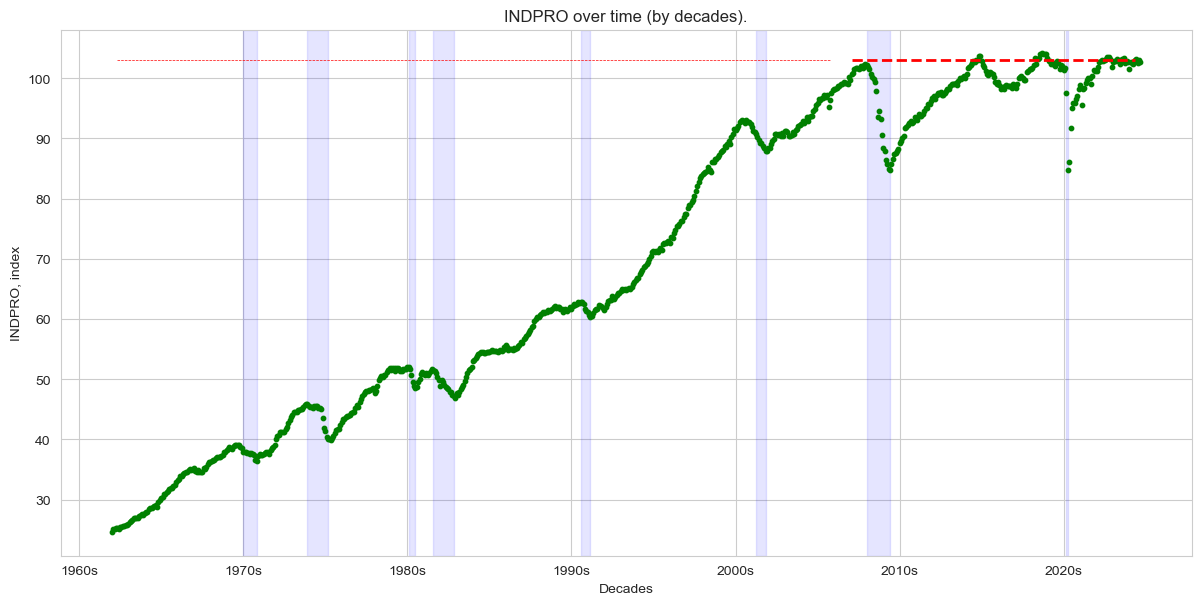

In [94]:
create_recession_chart()
# We make sure that the 'date' column is of type datetime.
indpro['date'] = pd.to_datetime(indpro['date'])
plt.scatter(indpro['date'], indpro['indpro'], s=10, color='green')  # s = the point size
# Readability settings.
plt.ylabel('INDPRO, index')
plt.title('INDPRO over time (by decades).')
# Add a horizontal line.
plt.axhline(y=103, color='r', linestyle='--', xmin = 0.05, xmax = 0.68, linewidth=0.5)
plt.axhline(y=103, color='r', linestyle='--', xmin = 0.70, xmax = 0.95, linewidth=2)
plt.show()

   After the recession in 2008, we don't have an increase in industrial production, do we? We are not talking about the so-called "service economy".

7. How long can the effect of "helicopter money" ([US Debt Clock](https://usdebtclock.org/)) last? According to economists dealing with the subject, until the debts reach 200% of the Gross Domestic Product (GDP). In a bad geopolitical situation up to 175%. [15] But this is already the subject of further research...
8. Still, will they declare a recession? Let's see. Before a recession, the poor stock up on salt, sugar, canned goods. Bankers stock up on... **gold**!<br>
I.e. before a recession or depression, the price of gold jumps a lot! On 23 October 2024, the price of gold reached an **all-time high** in real and nominal terms. [16] Even the peak around the 1980s recession, adjusted for inflation, is now smaller than the last one. I leave the conclusions to you...

### Resources:
1. **Recession Prediction using Machine Learning** https://towardsdatascience.com/recession-prediction-using-machine-learning-de6eee16ca94
2. **Real-time Sahm Rule Recession Indicator** https://fred.stlouisfed.org/series/SAHMREALTIME
3. **Industrial Production: Total Index** https://fred.stlouisfed.org/series/INDPRO
4. **Historical data: S&P 500 - U.S.** https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m
5. **Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity** https://fred.stlouisfed.org/series/dgs10
6. **10-Year Treasury Constant Maturity Minus Federal Funds Rate** https://fred.stlouisfed.org/series/T10YFF
7. **Monthly Unemployment Rate** https://fred.stlouisfed.org/series/UNRATE
8. **Personal Consumption Expenditures: Chain-type Price Index** https://fred.stlouisfed.org/series/PCEPI
9. **Total Nonfarm Payroll** https://fred.stlouisfed.org/series/PAYEMS
10. **New Privately-Owned Housing Units Started: Total Units** https://fred.stlouisfed.org/series/HOUST
11. **NBER based Recession Indicators for the United States** https://fred.stlouisfed.org/series/USREC
12. **Why we have to remove highly correlated features in Machine Learning?** https://medium.com/@sujathamudadla1213/why-we-have-to-remove-highly-correlated-features-in-machine-learning-9a8416286f18
13. **Autoregressive integrated moving average** https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average#External_links
14. **Projected monthly probability of a recession in the United States from August 2020 to August 2025** https://www.statista.com/statistics/1239080/us-monthly-projected-recession-probability/
16. **Bloomberg: US stuck in debt denial** https://opposition.bg/bloomberg-sasht-zamryaha-v-sastoyanie-na-otritsanie-na-dalga/
17. **Gold reached its highest price in history** https://tavex.bg/zlatoto-dostigna-naj-visokata-si-cena-v-istoriyata/